In [1]:
import os
import deeplabcut as dlc
import numpy as np
import scipy.io as io
import pandas as pd
import cv2
import struct
import matplotlib.pyplot as plt
import h5py

Loading DLC 2.3.0...


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def readSeq(video_path, frame):
    fid = open(video_path, 'rb')
    fidIdx = open(video_path + '.idx', 'rb')

    if frame == 1:
        readStart = 1028
        fidIdx.seek(8)
        imageBufferSize = int.from_bytes(fidIdx.read(4), byteorder='little', signed=False)
    else:
        readStartIdx = frame*24
        fidIdx.seek(readStartIdx)
        readStart = int.from_bytes(fidIdx.read(8), byteorder='little', signed=False) + 4
        imageBufferSize = int.from_bytes(fidIdx.read(4), byteorder='little', signed=False)


    fid.seek(readStart)

    JpegSEQ = np.frombuffer(fid.read(imageBufferSize), dtype=np.uint8)

    I = cv2.imdecode(JpegSEQ, np.uint8(0))

    fid.close()
    fidIdx.close()
    
    return I

def read_header(video_path):
    ifile = open(video_path, 'rb')

    feed = ifile.read(4)
    norpix = ifile.read(24)
    version = struct.unpack('@i', ifile.read(4))
    descr = ifile.read(512)
    length = struct.unpack('@i', ifile.read(4))
    assert (length != 1024)
    params = [struct.unpack('@i', ifile.read(4))[0] for i in range(0, 9)]
    fps = struct.unpack('@d', ifile.read(8))
    # skipping the rest
    ifile.read(432)
    image_ext = {100: 'raw', 102: 'jpg', 201: 'jpg', 1: 'png', 2: 'png'}

    ifile.close()
    return {'w': params[0], 'h': params[1],
            'bdepth': params[2],
            'ext': image_ext[params[5]],
            'format': params[5],
            'size': params[4],
            'true_size': params[8],
            'num_frames': params[6]}

def create_images(img, frame, dir_image):
    if not os.path.exists(dir_image):
        os.makedirs(dir_image)
    filename = os.path.join(dir_image, str(frame).zfill(6)+'.png')
    cv2.imwrite(filename, img)

def get_angle(pos_left_ear, pos_right_ear):
    angle = np.arctan2(pos_left_ear[1]-pos_right_ear[1], pos_left_ear[0]-pos_right_ear[0])
    return angle

def sub_angle(angle1, angle2):
    d = angle2-angle1
    if d>np.pi:
        d = d-2*np.pi
    elif d<-np.pi:
        d = d+2*np.pi
    return d

def merge_dataframe(df_all):
    df_out = pd.concat(df_all)
    df_out = df_out.sort_values(by=('bodyparts','coords'))
    return df_out

def add_new_folder(df, image_dir_new, dlc_model):
    dlc.analyze_time_lapse_frames(dlc_model, image_dir_new, frametype='png', save_as_csv=True)
    folder = os.path.basename(os.path.dirname(image_dir_new))

    csv_filename = get_full_filename(image_dir_new, '.csv')
    df_new = pd.read_csv(csv_filename, header=[1,2])
    return merge_dataframe((df, df_new))

def find_next_good_frame(p_head, idx):
    for k in range(idx+1, len(p_head)):
        if p_head[k]>=p_thres:
            return k
    return -1

def find_nearest_good_frames(p_head, idx):
    fa = -1
    fb = -1
    for k in range(idx-1, -1, -1):
        if p_head[k]>=p_thres:
            fa = k
            break
    for k in range(idx+1, len(p_head)):
        if p_head[k]>=p_thres:
            fb = k
            break
    return fa, fb

def find_new_frames_to_analyze(df, p_thres, v_angle_thres, n_points=4, n_frames=50):
    image_filenames = df['bodyparts']['coords'].to_list()
    idx_frame = np.array([int(x[:-4]) for x in image_filenames])

    pos_left_ear = np.stack((df['left_ear']['x'].to_numpy(),df['left_ear']['y'].to_numpy()), axis=0)
    pos_right_ear = np.stack((df['right_ear']['x'].to_numpy(),df['right_ear']['y'].to_numpy()), axis=0)

    ll = df['left_ear']['likelihood'].to_numpy()
    lr = df['right_ear']['likelihood'].to_numpy()

    p_head = np.min(np.stack((ll, lr), axis=0), axis=0)

    new_frames_to_analyze = []

    for k in range(len(p_head)):
        if p_head[k]<p_thres:
            fa, fb = find_nearest_good_frames(p_head, k)
            if fa<0 or fb<0:
                continue

            d_angle = sub_angle(get_angle(pos_left_ear[:, fa], pos_right_ear[:, fa]), get_angle(pos_left_ear[:, fb], pos_right_ear[:, fb]))
            if idx_frame[fb]-idx_frame[fa]<=n_frames and np.abs(d_angle)<v_angle_thres:
                continue

            # sample 4 points in between fa and fb
            is_point_added = False
            point_added = 0
            while (not is_point_added) and point_added<=2: 
                frames_sample = np.linspace(idx_frame[fa], idx_frame[fb], n_points+point_added+1).astype(int)
                point_added += 1
                for frame in frames_sample:
                    if frame in idx_frame:
                        continue
                    else:
                        new_frames_to_analyze.append(frame)
                        is_point_added = True

        else:
            fa = k
            fb = find_next_good_frame(p_head, k)
            if fb<0:
                continue

            d_angle = sub_angle(get_angle(pos_left_ear[:, fa], pos_right_ear[:, fa]), get_angle(pos_left_ear[:, fb], pos_right_ear[:, fb]))
            if np.abs(d_angle)<v_angle_thres:
                continue
            
            # sample 4 points in between fa and fb
            is_point_added = False
            point_added = 0
            while (not is_point_added) and point_added<=2: 
                frames_sample = np.linspace(idx_frame[fa], idx_frame[fb], n_points+point_added+1).astype(int)
                point_added += 1
                for frame in frames_sample:
                    if frame in idx_frame:
                        continue
                    else:
                        new_frames_to_analyze.append(frame)
                        is_point_added = True

    return sorted(set(new_frames_to_analyze))

def get_full_filename(dir_image, extension):
    filenames = os.listdir(dir_image)
    filenames = [x for x in filenames if x.endswith(extension)]
    filenames = [os.path.join(dir_image, x) for x in filenames]
    if len(filenames)>1:
        os.error('More than one file with extension '+extension+' in '+dir_image)
    return filenames[0]

def analyze_segment(segment_num, video_path, dir_temp, dir_save):
    meta = read_header(video_path)
    frames_to_analyze = np.arange(1, meta['num_frames'], frame_interval).tolist()
    dir_image = os.path.join(dir_temp, 'Image_Segment'+str(segment_num))
    
    for frame in frames_to_analyze:
        temp_filename = os.path.join(dir_image, str(frame).zfill(6)+'.png')
        if os.path.isfile(temp_filename):
            continue
        I = readSeq(video_path, frame)
        create_images(I, frame, dir_image)  

    dlc.analyze_time_lapse_frames(dlc_model, dir_image, frametype='png', save_as_csv=True)
    csv_filename = get_full_filename(dir_image, 'csv')
    df = pd.read_csv(csv_filename, header=[1,2])

    new_frames_to_analyze = find_new_frames_to_analyze(df, p_thres, v_angle_thres)
    count = 1
    while len(new_frames_to_analyze)>0:
        dir_new_frames = os.path.join(dir_temp,'New'+str(count)+'_Segment'+str(segment_num)+'/')
        if not os.path.exists(dir_new_frames):
            os.makedirs(dir_new_frames)

        for frame in new_frames_to_analyze:
            temp_filename = dir_new_frames+str(frame).zfill(6)+'.png'
            if os.path.isfile(temp_filename):
                continue
            I = readSeq(video_path, frame)
            create_images(I, frame, dir_new_frames)

        df = add_new_folder(df, dir_new_frames, dlc_model)
        count = count+1

        new_frames_to_analyze = find_new_frames_to_analyze(df, p_thres, v_angle_thres)

    # Get the final result
    pos_left_ear = np.stack((df['left_ear']['x'].to_numpy(),df['left_ear']['y'].to_numpy()), axis=0)
    pos_right_ear = np.stack((df['right_ear']['x'].to_numpy(),df['right_ear']['y'].to_numpy()), axis=0)

    ll = df['left_ear']['likelihood'].to_numpy()
    lr = df['right_ear']['likelihood'].to_numpy()

    p_head = np.min(np.stack((ll, lr), axis=0), axis=0)
    angle = np.array([get_angle(pos_left_ear[:,k], pos_right_ear[:,k]) for k in range(len(p_head))])

    image_filenames = df['bodyparts']['coords'].to_list()
    idx_frame = np.array([int(x[:-4]) for x in image_filenames])

    angle_good = angle[p_head>=p_thres]
    idx_good = idx_frame[p_head>=p_thres]
    print(len(angle_good), 'out of', len(angle), 'frames are good.')

    d_angle = np.array([sub_angle(angle_good[k-1], angle_good[k]) for k in range(1,len(angle_good))])
    d_angle = np.concatenate((np.array([0]), d_angle))

    d_idx = np.array([idx_good[k]-idx_good[k-1] for k in range(1,len(idx_good))])
    d_idx = np.concatenate((np.array([1]), d_idx))

    # filter the jumped point: d_angle>v_thres and d_idx==1
    idx_good_filtered = []
    for k in range(len(d_angle)):
        if not(np.abs(d_angle[k])>v_angle_thres and d_idx[k]==1):
            idx_good_filtered.append(k)

    print(len(idx_good_filtered), 'out of', len(angle_good), 'frames are good after filtering.')

    angle_filtered = angle_good[idx_good_filtered]
    idx_filtered = idx_good[idx_good_filtered]
    d_angle_filtered = np.array([sub_angle(angle_filtered[k-1], angle_filtered[k]) for k in range(1,len(angle_filtered))])
    d_angle_filtered = np.concatenate((np.array([0]), d_angle_filtered))

    d_idx_filtered = np.array([idx_filtered[k]-idx_filtered[k-1] for k in range(1,len(idx_filtered))])
    d_idx_filtered = np.concatenate((np.array([1]), d_idx_filtered))

    # save the data
    pos_left_ear_good = pos_left_ear[:,p_head>=p_thres]
    pos_right_ear_good = pos_right_ear[:,p_head>=p_thres]
    p_left_ear_good = ll[p_head>=p_thres]
    p_right_ear_good = lr[p_head>=p_thres]
    p_head_good = p_head[p_head>=p_thres]

    pos_left_ear_filtered = pos_left_ear_good[:,idx_good_filtered]
    pos_right_ear_filtered = pos_right_ear_good[:,idx_good_filtered]
    p_left_ear_filtered = p_left_ear_good[idx_good_filtered]
    p_right_ear_filtered = p_right_ear_good[idx_good_filtered]
    p_head_filtered = p_head_good[idx_good_filtered]


    df_out = pd.DataFrame({
        'frame_number': idx_filtered,
        'angle': angle_filtered, 
        'd_angle': d_angle_filtered,
        'turning_angle': np.cumsum(d_angle_filtered), 
        'x_left_ear': pos_left_ear_filtered[0,:],
        'y_left_ear': pos_left_ear_filtered[1,:], 
        'x_right_ear': pos_right_ear_filtered[0,:],
        'y_right_ear': pos_right_ear_filtered[1,:],
        'p_left_ear': p_left_ear_filtered,
        'p_right_ear': p_right_ear_filtered,
        'p_head': p_head_filtered})

    df_out.to_csv(os.path.join(dir_save, 'turning_angle_segment'+str(segment_num)+'.csv'), index=False)

    return df_out

Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220817_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\Image_Segment1
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\Image_Segment1\Image_Segment1DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  979  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 970/979 [00:54<00:00, 17.93it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  759  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 750/759 [00:31<00:00, 24.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  593  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 590/593 [00:25<00:00, 22.97it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  504  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 500/504 [00:20<00:00, 24.29it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  433  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 430/433 [00:17<00:00, 23.90it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  256  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 250/256 [00:10<00:00, 23.32it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  123  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 120/123 [00:05<00:00, 22.31it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  107  found with (before cropping) frame dimensions:  1000 750


 93%|█████████▎| 100/107 [00:04<00:00, 21.15it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  40  found with (before cropping) frame dimensions:  1000 750


 75%|███████▌  | 30/40 [00:01<00:00, 16.10it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  27  found with (before cropping) frame dimensions:  1000 750


 74%|███████▍  | 20/27 [00:01<00:00, 13.37it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  20  found with (before cropping) frame dimensions:  1000 750


 50%|█████     | 10/20 [00:01<00:01,  8.62it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2703 out of 5639 frames are good.
2702 out of 2703 frames are good after filtering.


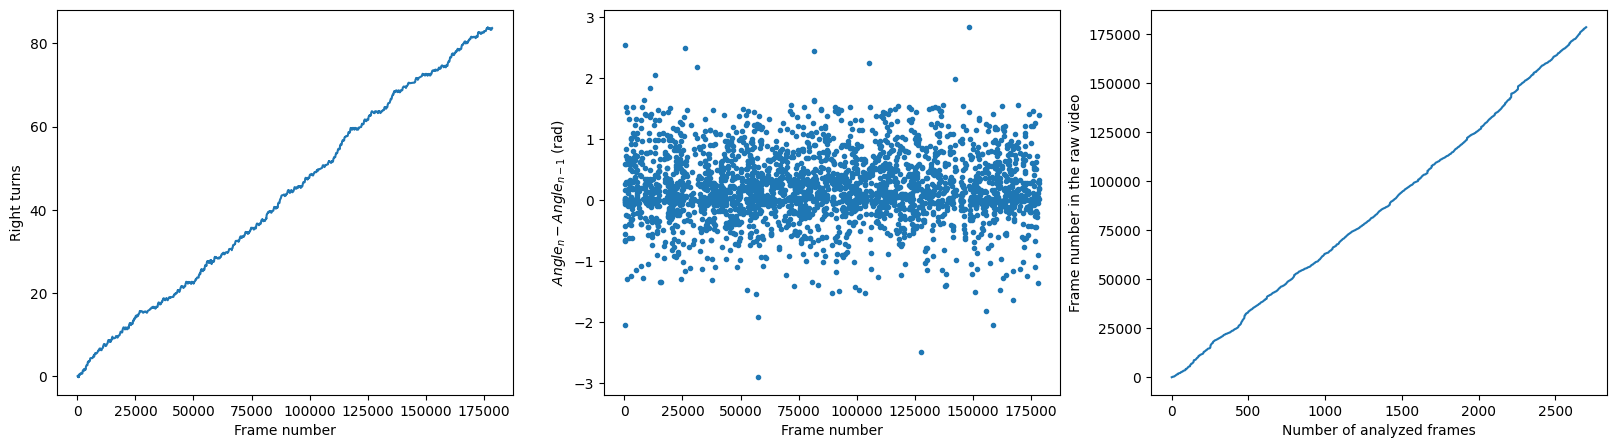

The animal made 83.68751489838877 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\Image_Segment2
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\Image_Segment2\Image_Segment2DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  989  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 980/989 [00:40<00:00, 24.20it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  976  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 970/976 [00:39<00:00, 24.50it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  931  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 930/931 [00:37<00:00, 24.55it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  864  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 860/864 [00:35<00:00, 24.18it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  658  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 650/658 [00:27<00:00, 23.69it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  411  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 410/411 [00:17<00:00, 23.65it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  220  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 210/220 [00:09<00:00, 22.18it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  127  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 120/127 [00:05<00:00, 21.78it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  61  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 60/61 [00:02<00:00, 21.36it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  46  found with (before cropping) frame dimensions:  1000 750


 87%|████████▋ | 40/46 [00:02<00:00, 19.12it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  15  found with (before cropping) frame dimensions:  1000 750


 67%|██████▋   | 10/15 [00:00<00:00, 11.61it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  11  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 10/11 [00:00<00:00, 12.40it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New14_Segment2/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New14_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2432 out of 7109 frames are good.
2431 out of 2432 frames are good after filtering.


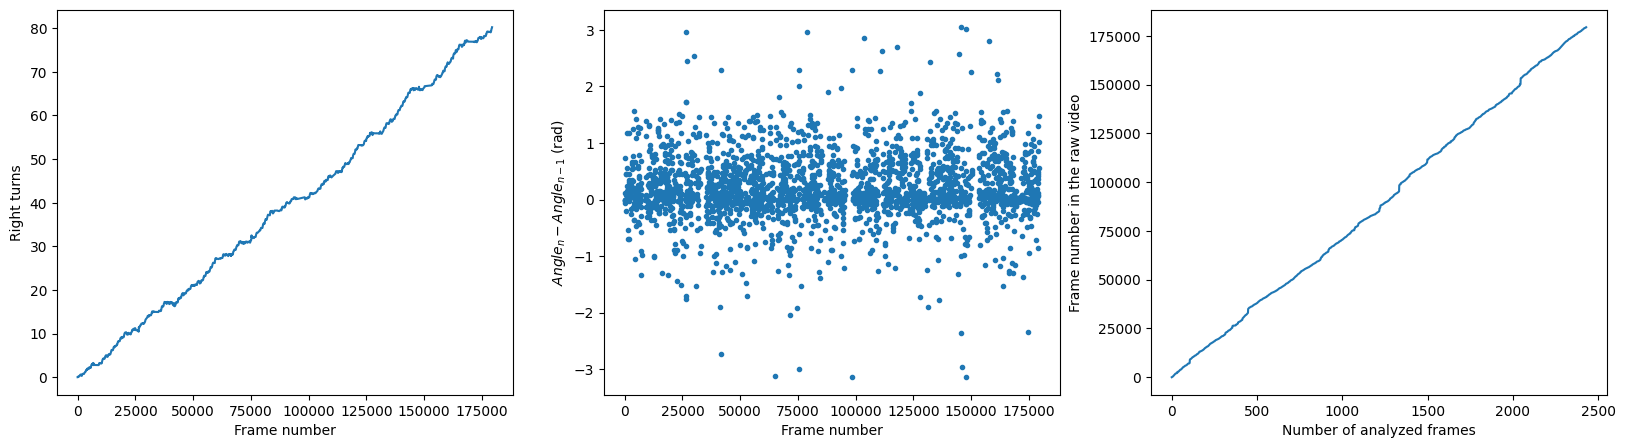

The animal made 80.23727936729985 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\Image_Segment3
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\Image_Segment3\Image_Segment3DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  745  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 740/745 [00:30<00:00, 23.94it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  722  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 720/722 [00:29<00:00, 24.25it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  662  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 660/662 [00:27<00:00, 23.99it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  594  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 590/594 [00:24<00:00, 24.04it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  499  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 490/499 [00:20<00:00, 23.59it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  325  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 320/325 [00:13<00:00, 23.55it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  179  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▍| 170/179 [00:07<00:00, 22.12it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  88  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 80/88 [00:03<00:00, 21.05it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  21  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 20/21 [00:01<00:00, 16.72it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  13  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 10/13 [00:00<00:00, 11.71it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New11_Segment3/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220817_video\Temp\New11_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2065 out of 5532 frames are good.
2065 out of 2065 frames are good after filtering.


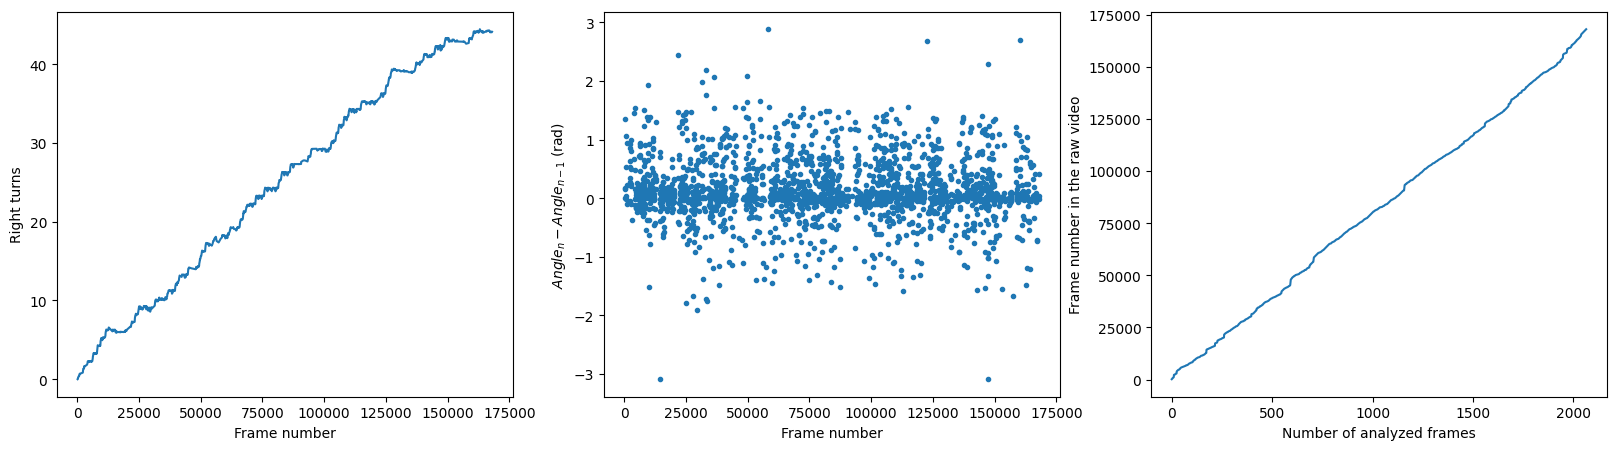

The animal made 44.12531064028797 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220818_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\Image_Segment1
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\Image_Segment1\Image_Segment1DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  918  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 910/918 [00:37<00:00, 24.11it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  686  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 680/686 [00:28<00:00, 24.23it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  626  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 620/626 [00:25<00:00, 23.90it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  557  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 550/557 [00:23<00:00, 23.87it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  473  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 470/473 [00:19<00:00, 23.57it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  270  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▋| 260/270 [00:11<00:00, 23.27it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  162  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 160/162 [00:06<00:00, 22.98it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  105  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 100/105 [00:04<00:00, 21.47it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  21  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 20/21 [00:01<00:00, 17.33it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  21  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 20/21 [00:01<00:00, 17.28it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  12  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 10/12 [00:00<00:00, 12.28it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  5  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/5 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New14_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New14_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New15_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New15_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New16_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New16_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2670 out of 5667 frames are good.
2668 out of 2670 frames are good after filtering.


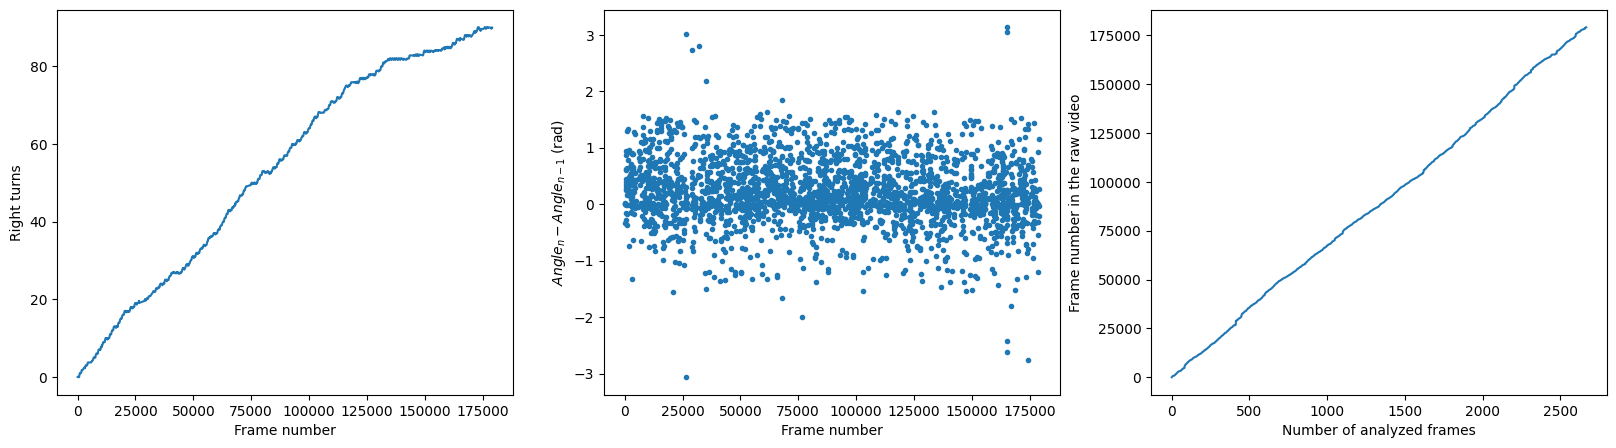

The animal made 90.00444437398079 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\Image_Segment2
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\Image_Segment2\Image_Segment2DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  764  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 760/764 [00:31<00:00, 23.96it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  891  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 890/891 [00:36<00:00, 24.31it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  908  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 900/908 [00:37<00:00, 24.26it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  832  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 830/832 [00:34<00:00, 24.12it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  681  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 680/681 [00:28<00:00, 24.09it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  407  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 400/407 [00:16<00:00, 23.83it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  236  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 230/236 [00:09<00:00, 23.03it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  130  found with (before cropping) frame dimensions:  1000 750


 92%|█████████▏| 120/130 [00:05<00:00, 21.13it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  47  found with (before cropping) frame dimensions:  1000 750


 85%|████████▌ | 40/47 [00:02<00:00, 18.10it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  36  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 30/36 [00:01<00:00, 16.04it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2299 out of 6747 frames are good.
2297 out of 2299 frames are good after filtering.


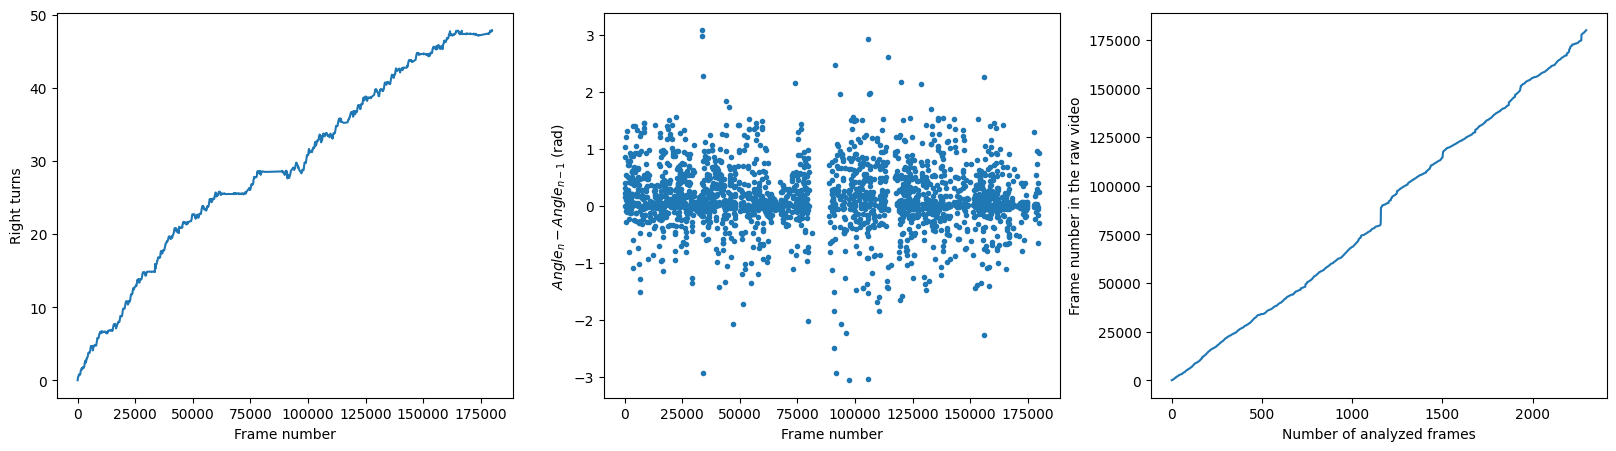

The animal made 47.861061163782324 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\Image_Segment3
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\Image_Segment3\Image_Segment3DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  671  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 670/671 [00:27<00:00, 24.24it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  558  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 550/558 [00:23<00:00, 23.69it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  459  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 450/459 [00:19<00:00, 23.58it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  405  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 400/405 [00:16<00:00, 23.88it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  275  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 270/275 [00:11<00:00, 23.42it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  178  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 170/178 [00:07<00:00, 22.30it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  104  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 100/104 [00:04<00:00, 22.38it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  72  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 70/72 [00:03<00:00, 21.84it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  26  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 20/26 [00:01<00:00, 13.41it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  17  found with (before cropping) frame dimensions:  1000 750


 59%|█████▉    | 10/17 [00:01<00:00,  8.85it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New11_Segment3/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220818_video\Temp\New11_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2228 out of 4544 frames are good.
2228 out of 2228 frames are good after filtering.


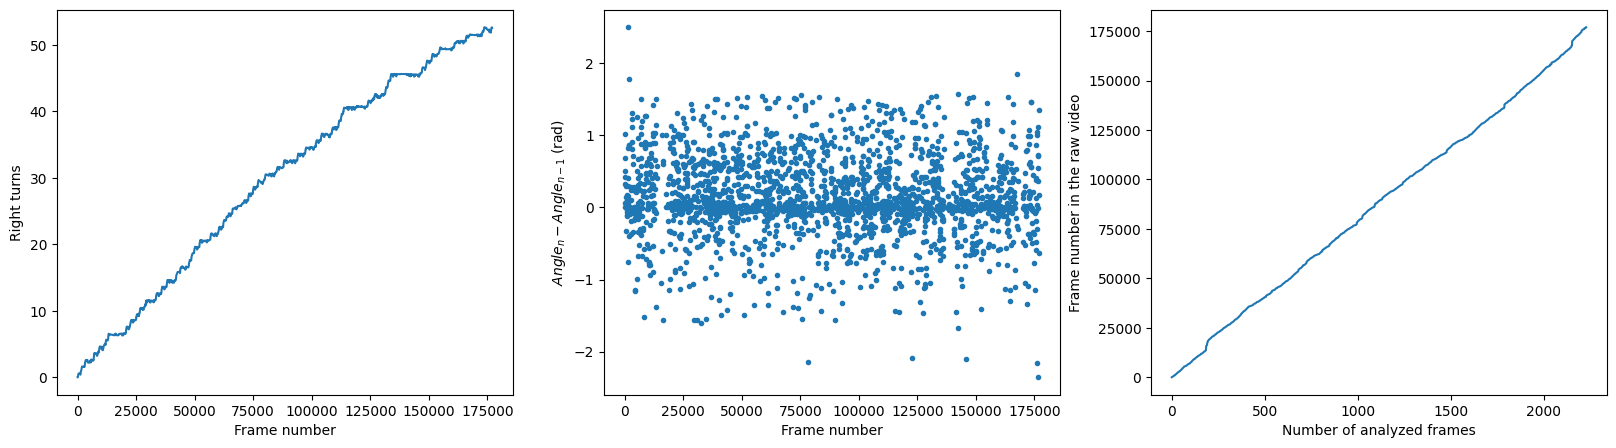

The animal made 52.536536679696304 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220819_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\Image_Segment1
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\Image_Segment1\Image_Segment1DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  907  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 900/907 [00:37<00:00, 24.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  619  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 610/619 [00:25<00:00, 23.69it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  591  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 590/591 [00:24<00:00, 24.24it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  525  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 520/525 [00:21<00:00, 24.28it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  406  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 400/406 [00:16<00:00, 23.81it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  240  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 230/240 [00:10<00:00, 22.94it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  149  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 140/149 [00:06<00:00, 21.81it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  108  found with (before cropping) frame dimensions:  1000 750


 93%|█████████▎| 100/108 [00:04<00:00, 21.22it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  47  found with (before cropping) frame dimensions:  1000 750


 85%|████████▌ | 40/47 [00:02<00:00, 18.33it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  15  found with (before cropping) frame dimensions:  1000 750


 67%|██████▋   | 10/15 [00:00<00:00, 11.88it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2484 out of 5418 frames are good.
2481 out of 2484 frames are good after filtering.


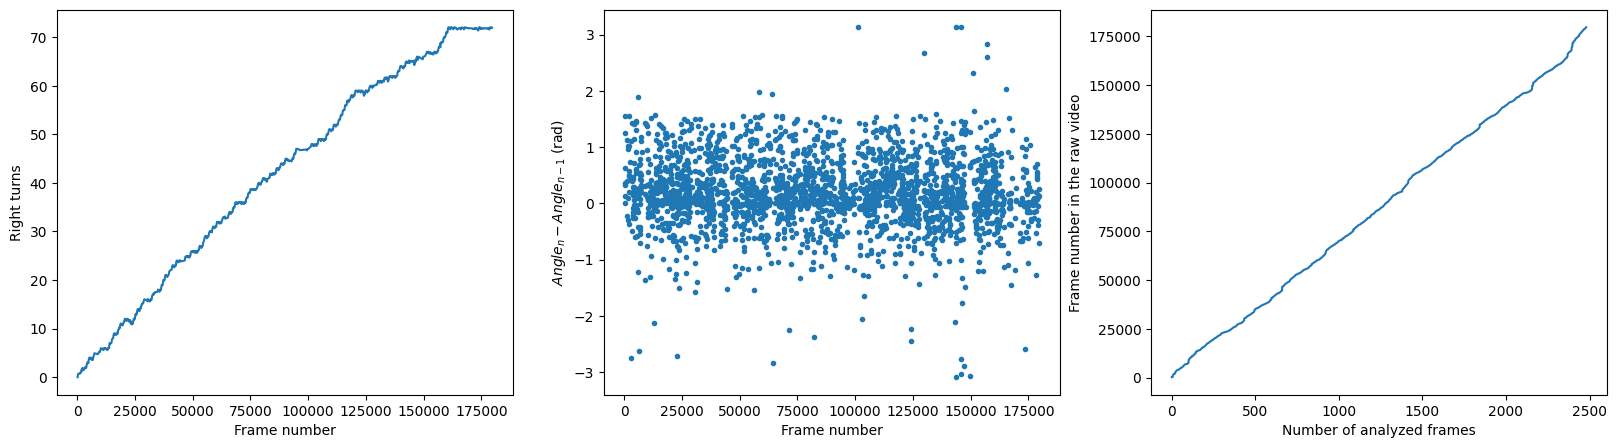

The animal made 71.9168779722037 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\Image_Segment2
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\Image_Segment2\Image_Segment2DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  739  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 730/739 [00:30<00:00, 23.91it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  837  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 830/837 [00:34<00:00, 24.11it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  797  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 790/797 [00:32<00:00, 24.22it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  688  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 680/688 [00:28<00:00, 24.03it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  522  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 520/522 [00:21<00:00, 23.97it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  331  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 330/331 [00:13<00:00, 23.87it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  209  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 200/209 [00:08<00:00, 22.29it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  103  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 100/103 [00:04<00:00, 22.20it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  60  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 50/60 [00:02<00:00, 17.65it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  36  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 30/36 [00:01<00:00, 16.37it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  17  found with (before cropping) frame dimensions:  1000 750


 59%|█████▉    | 10/17 [00:01<00:00,  8.93it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2188 out of 6143 frames are good.
2184 out of 2188 frames are good after filtering.


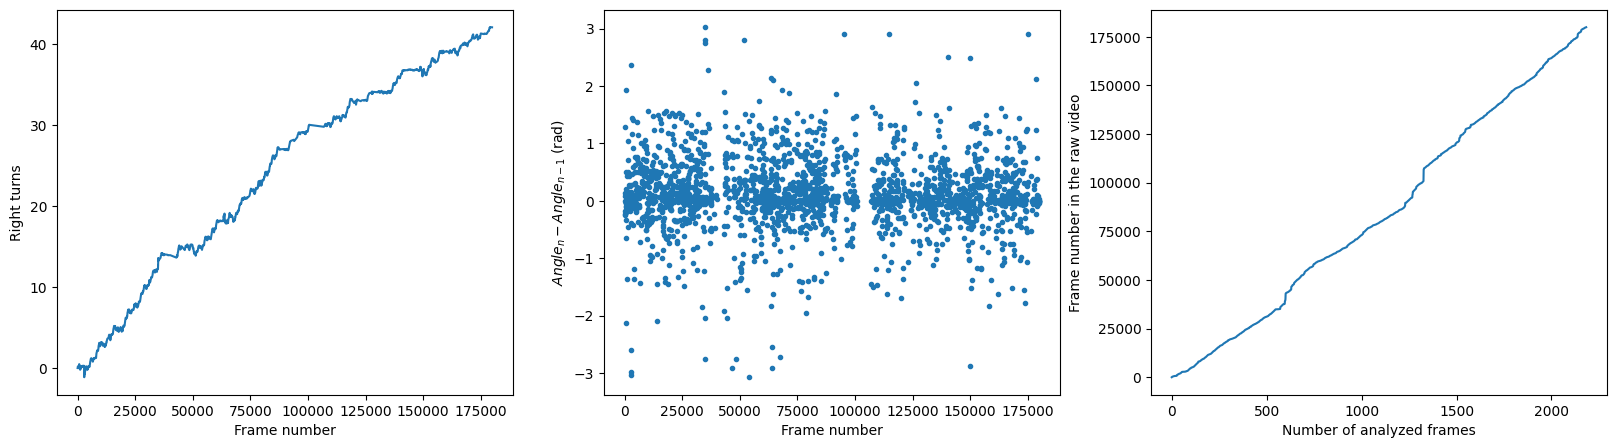

The animal made 42.02502884411369 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\Image_Segment3
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\Image_Segment3\Image_Segment3DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  691  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 690/691 [00:28<00:00, 24.52it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  730  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 720/730 [00:30<00:00, 23.89it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  689  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 680/689 [00:28<00:00, 23.74it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  605  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 600/605 [00:24<00:00, 24.14it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  471  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 470/471 [00:19<00:00, 24.19it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  304  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 300/304 [00:12<00:00, 23.52it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  163  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 160/163 [00:07<00:00, 22.65it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  111  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 110/111 [00:04<00:00, 22.77it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  25  found with (before cropping) frame dimensions:  1000 750


 80%|████████  | 20/25 [00:01<00:00, 14.11it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  14  found with (before cropping) frame dimensions:  1000 750


 71%|███████▏  | 10/14 [00:00<00:00, 11.35it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New11_Segment3/
Starting to extract posture
Overall # of frames:  15  found with (before cropping) frame dimensions:  1000 750


 67%|██████▋   | 10/15 [00:00<00:00, 11.63it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220819_video\Temp\New11_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2277 out of 5617 frames are good.
2274 out of 2277 frames are good after filtering.


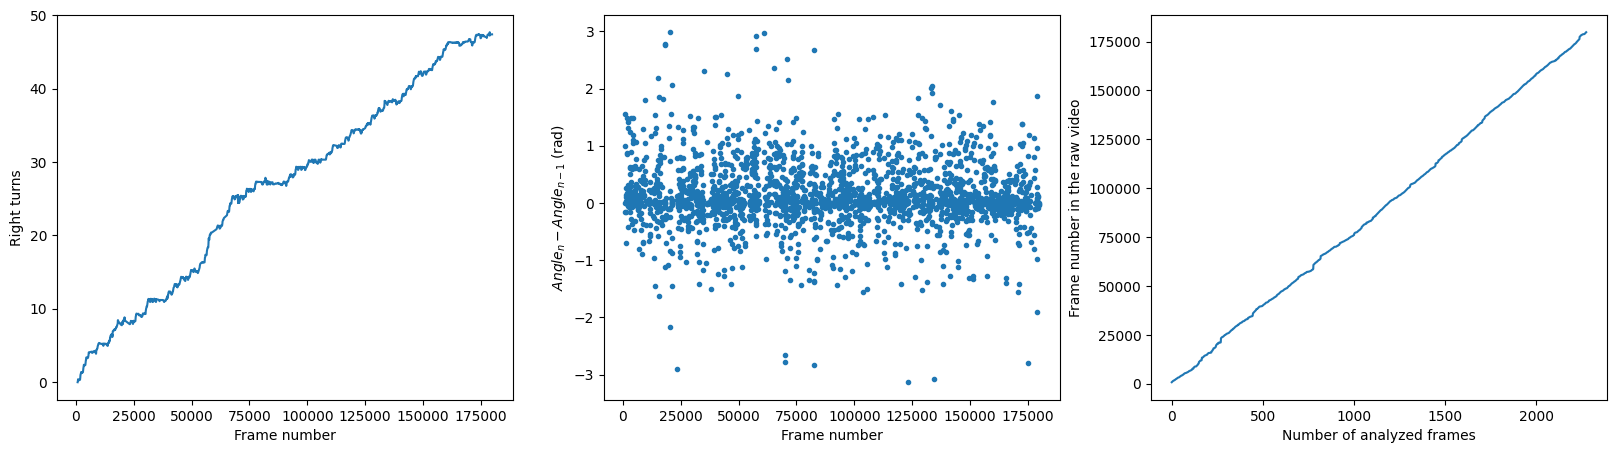

The animal made 47.411863430945914 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220823_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:13<00:00, 24.33it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  637  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 630/637 [00:26<00:00, 23.78it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  674  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 670/674 [00:27<00:00, 24.23it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  584  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 580/584 [00:24<00:00, 24.03it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  459  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 450/459 [00:19<00:00, 23.37it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  340  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 330/340 [00:14<00:00, 22.76it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  196  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 190/196 [00:08<00:00, 22.59it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  145  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 140/145 [00:06<00:00, 21.84it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  91  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 90/91 [00:04<00:00, 22.16it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  47  found with (before cropping) frame dimensions:  1000 750


 85%|████████▌ | 40/47 [00:02<00:00, 18.55it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  47  found with (before cropping) frame dimensions:  1000 750


 85%|████████▌ | 40/47 [00:02<00:00, 18.20it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  31  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 30/31 [00:01<00:00, 19.80it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  16  found with (before cropping) frame dimensions:  1000 750


 62%|██████▎   | 10/16 [00:00<00:00, 11.41it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/10 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New14_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New14_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New15_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New15_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New16_Segment1/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New16_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2124 out of 5085 frames are good.
2122 out of 2124 frames are good after filtering.


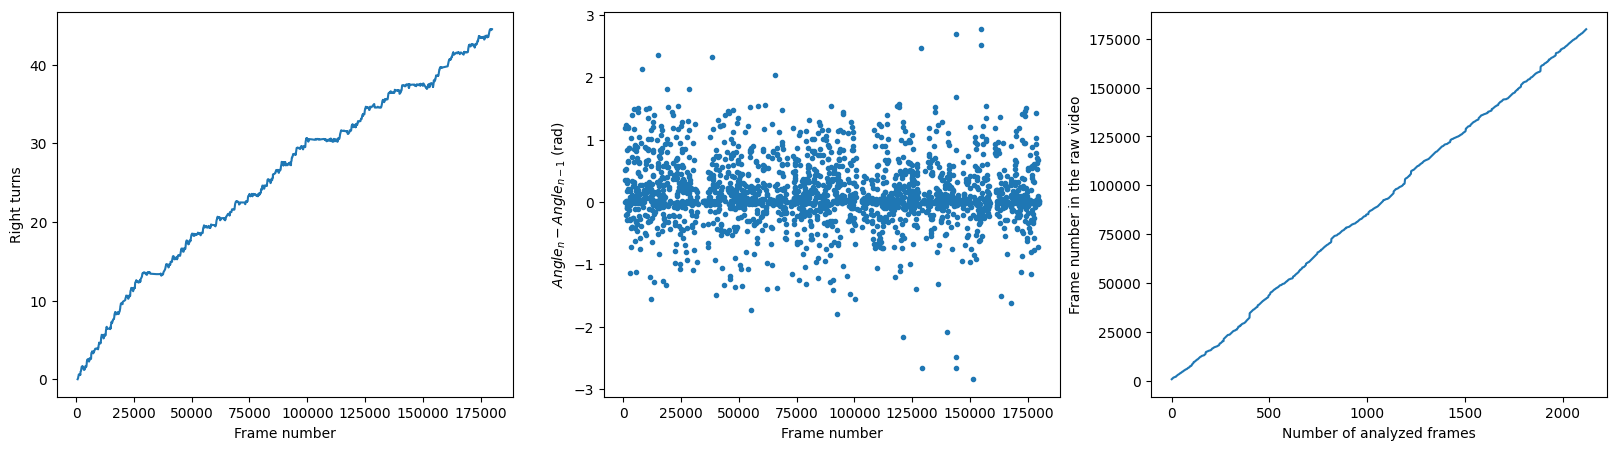

The animal made 44.51550621012616 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:14<00:00, 24.04it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  648  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 640/648 [00:26<00:00, 23.85it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  803  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 800/803 [00:33<00:00, 23.96it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  802  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 800/802 [00:32<00:00, 24.27it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  718  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 710/718 [00:29<00:00, 23.84it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  536  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 530/536 [00:22<00:00, 23.85it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  367  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 360/367 [00:15<00:00, 23.58it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  213  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 210/213 [00:09<00:00, 23.10it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  110  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 100/110 [00:04<00:00, 20.60it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  37  found with (before cropping) frame dimensions:  1000 750


 81%|████████  | 30/37 [00:01<00:00, 16.24it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  33  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 30/33 [00:01<00:00, 16.59it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/10 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2284 out of 6083 frames are good.
2282 out of 2284 frames are good after filtering.


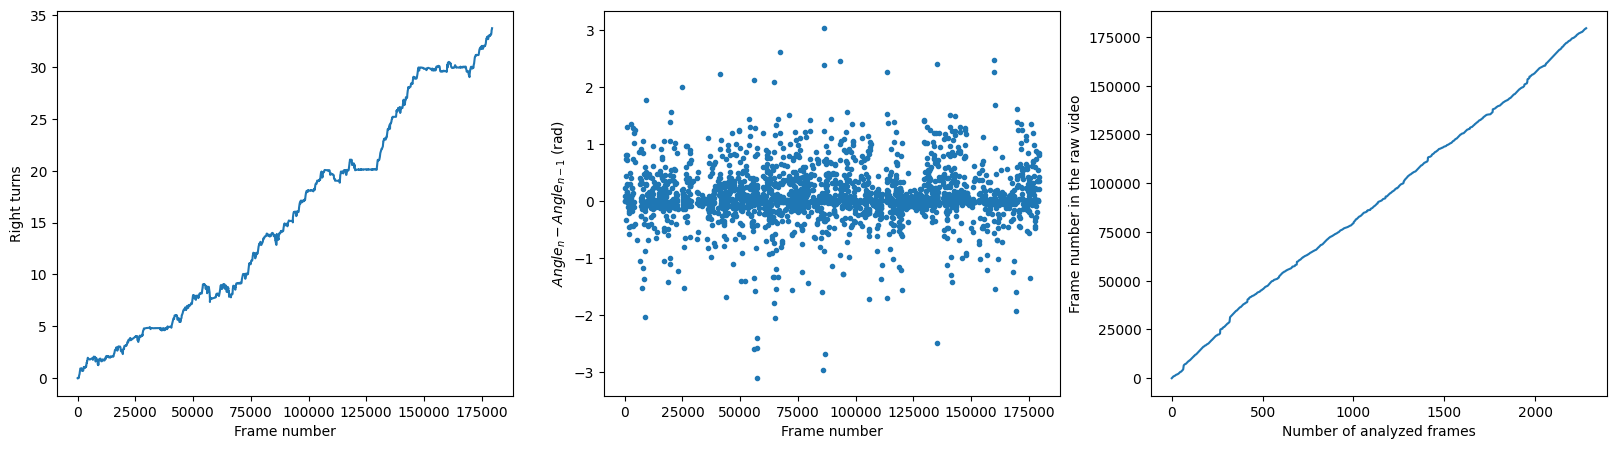

The animal made 33.742289156502764 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\Image_Segment3
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:13<00:00, 24.28it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\Image_Segment3...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  611  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 610/611 [00:25<00:00, 24.16it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  620  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 610/620 [00:25<00:00, 23.91it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  614  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 610/614 [00:25<00:00, 24.27it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  514  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 510/514 [00:21<00:00, 23.97it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  362  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 360/362 [00:15<00:00, 23.65it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  204  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 200/204 [00:08<00:00, 23.54it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  160  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 150/160 [00:06<00:00, 22.60it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  76  found with (before cropping) frame dimensions:  1000 750


 92%|█████████▏| 70/76 [00:03<00:00, 20.48it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  53  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 50/53 [00:02<00:00, 19.57it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  35  found with (before cropping) frame dimensions:  1000 750


 86%|████████▌ | 30/35 [00:01<00:00, 16.40it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New11_Segment3/
Starting to extract posture
Overall # of frames:  21  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 20/21 [00:01<00:00, 16.90it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New11_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New12_Segment3/
Starting to extract posture
Overall # of frames:  14  found with (before cropping) frame dimensions:  1000 750


 71%|███████▏  | 10/14 [00:00<00:00, 11.09it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New12_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New13_Segment3/
Starting to extract posture
Overall # of frames:  7  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/7 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New13_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New14_Segment3/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New14_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New15_Segment3/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220823_video\Temp\New15_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2176 out of 5101 frames are good.
2170 out of 2176 frames are good after filtering.


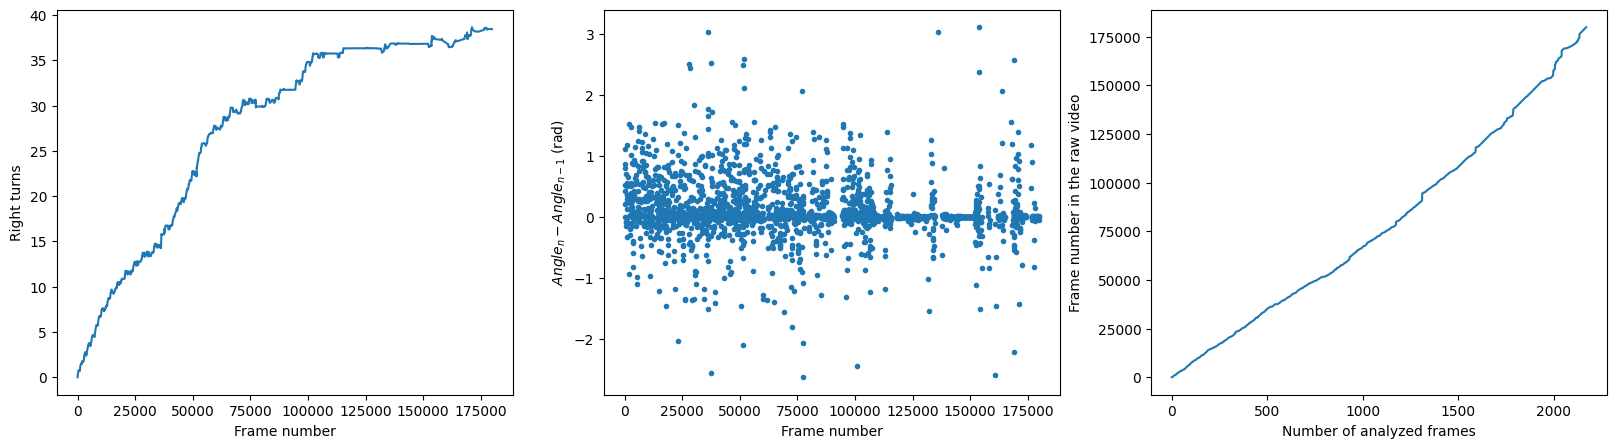

The animal made 38.437935461309046 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220824_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:13<00:00, 24.17it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  821  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 820/821 [00:34<00:00, 24.08it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  615  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 610/615 [00:25<00:00, 23.97it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  575  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 570/575 [00:23<00:00, 23.92it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  494  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 490/494 [00:20<00:00, 24.01it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  406  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 400/406 [00:16<00:00, 23.59it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  231  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 230/231 [00:09<00:00, 23.62it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  128  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 120/128 [00:05<00:00, 21.44it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  66  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 60/66 [00:03<00:00, 19.21it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  33  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 30/33 [00:01<00:00, 16.55it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  1000 750


 56%|█████▌    | 10/18 [00:01<00:00,  8.75it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  5  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/5 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2430 out of 5194 frames are good.
2429 out of 2430 frames are good after filtering.


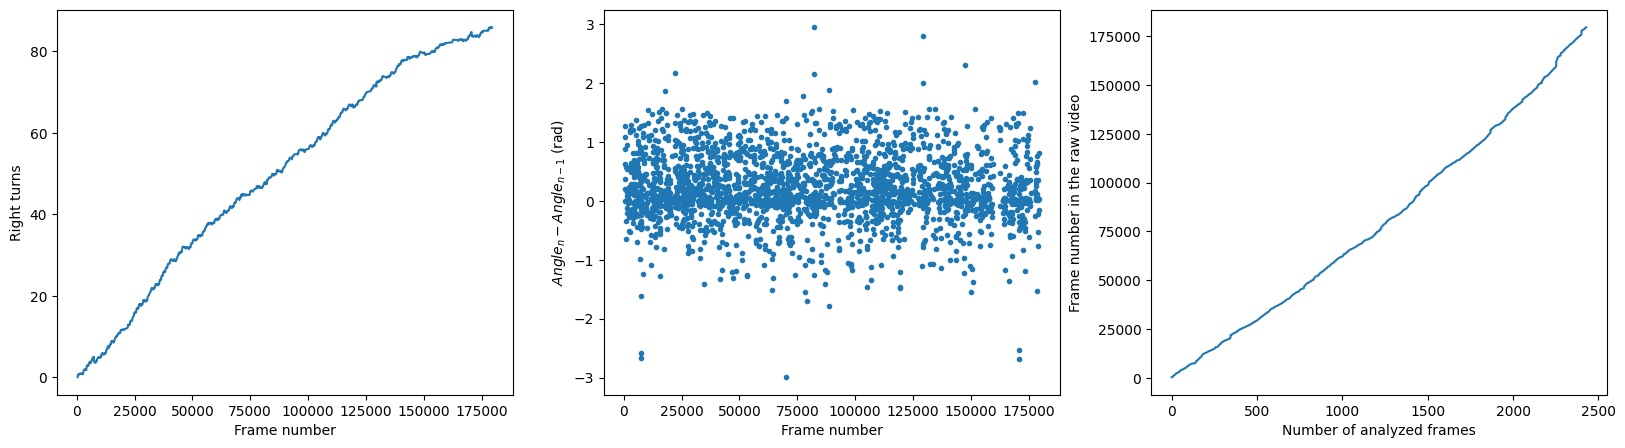

The animal made 85.8398756434849 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1783  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1768/1783 [01:12<00:00, 24.35it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  713  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 710/713 [00:29<00:00, 24.09it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  698  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 690/698 [00:29<00:00, 23.77it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  611  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 610/611 [00:25<00:00, 23.90it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  515  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 510/515 [00:21<00:00, 23.82it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  380  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 370/380 [00:16<00:00, 23.09it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  205  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 200/205 [00:08<00:00, 23.05it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  117  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 110/117 [00:05<00:00, 21.49it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  65  found with (before cropping) frame dimensions:  1000 750


 92%|█████████▏| 60/65 [00:03<00:00, 19.45it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  19  found with (before cropping) frame dimensions:  1000 750


 53%|█████▎    | 10/19 [00:01<00:01,  8.66it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2284 out of 5124 frames are good.
2284 out of 2284 frames are good after filtering.


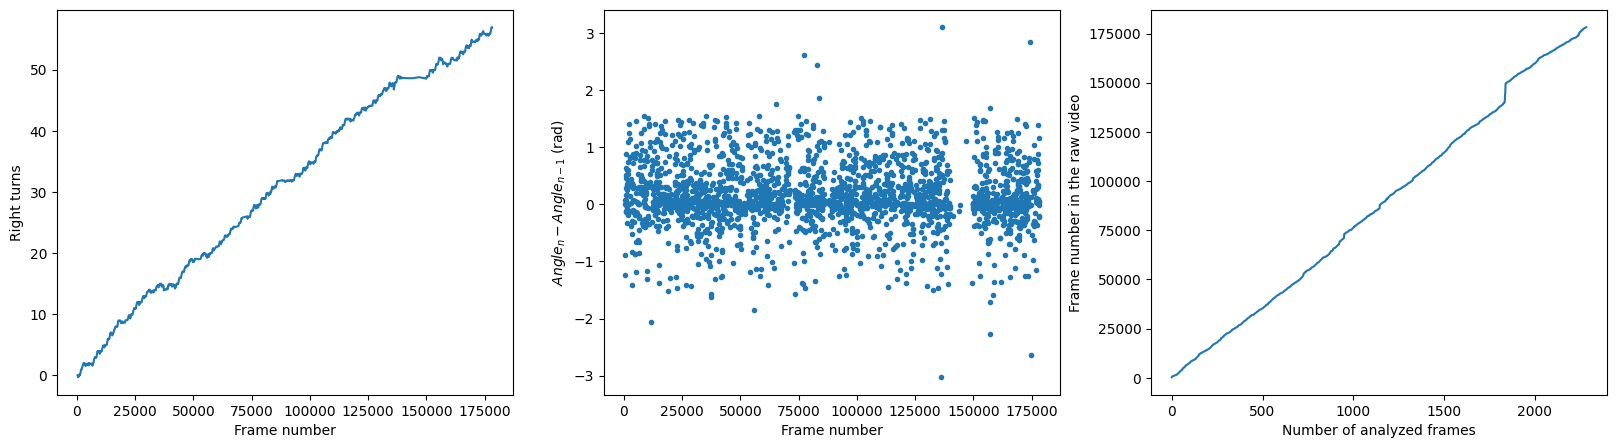

The animal made 56.88964863714523 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\Image_Segment3
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:14<00:00, 24.00it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\Image_Segment3...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  634  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 630/634 [00:26<00:00, 23.62it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  579  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 570/579 [00:24<00:00, 23.72it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  504  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 500/504 [00:21<00:00, 23.60it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  414  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 410/414 [00:17<00:00, 23.67it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  323  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 320/323 [00:13<00:00, 23.46it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  215  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 210/215 [00:09<00:00, 23.02it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  106  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 100/106 [00:04<00:00, 21.05it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  54  found with (before cropping) frame dimensions:  1000 750


 93%|█████████▎| 50/54 [00:02<00:00, 20.22it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  39  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 30/39 [00:01<00:00, 16.05it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  26  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 20/26 [00:01<00:00, 13.72it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New11_Segment3/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New11_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New12_Segment3/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New12_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New13_Segment3/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New13_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New14_Segment3/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New14_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New15_Segment3/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220824_video\Temp\New15_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2194 out of 4714 frames are good.
2193 out of 2194 frames are good after filtering.


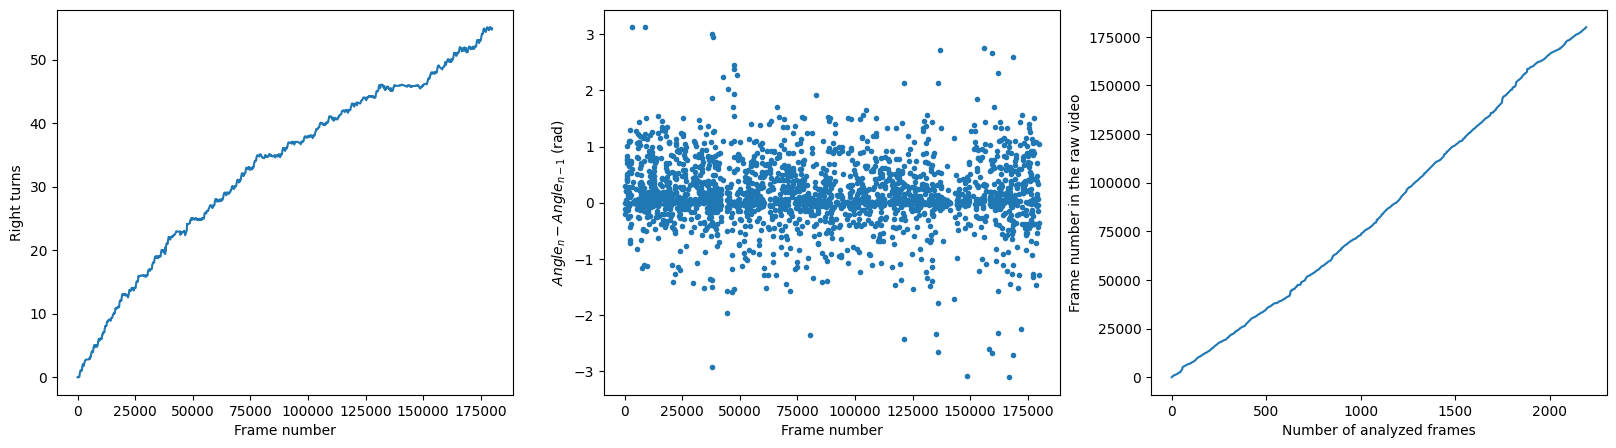

The animal made 54.88594885625671 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220825_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1778  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1768/1778 [01:12<00:00, 24.32it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  771  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 770/771 [00:32<00:00, 24.04it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  530  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 520/530 [00:22<00:00, 23.40it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  396  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 390/396 [00:16<00:00, 23.33it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  319  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 310/319 [00:13<00:00, 23.25it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  220  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 210/220 [00:09<00:00, 22.56it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  134  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 130/134 [00:05<00:00, 22.70it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  69  found with (before cropping) frame dimensions:  1000 750


 87%|████████▋ | 60/69 [00:03<00:00, 19.13it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  44  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 40/44 [00:02<00:00, 18.41it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/10 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  13  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 10/13 [00:00<00:00, 11.84it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2226 out of 4288 frames are good.
2224 out of 2226 frames are good after filtering.


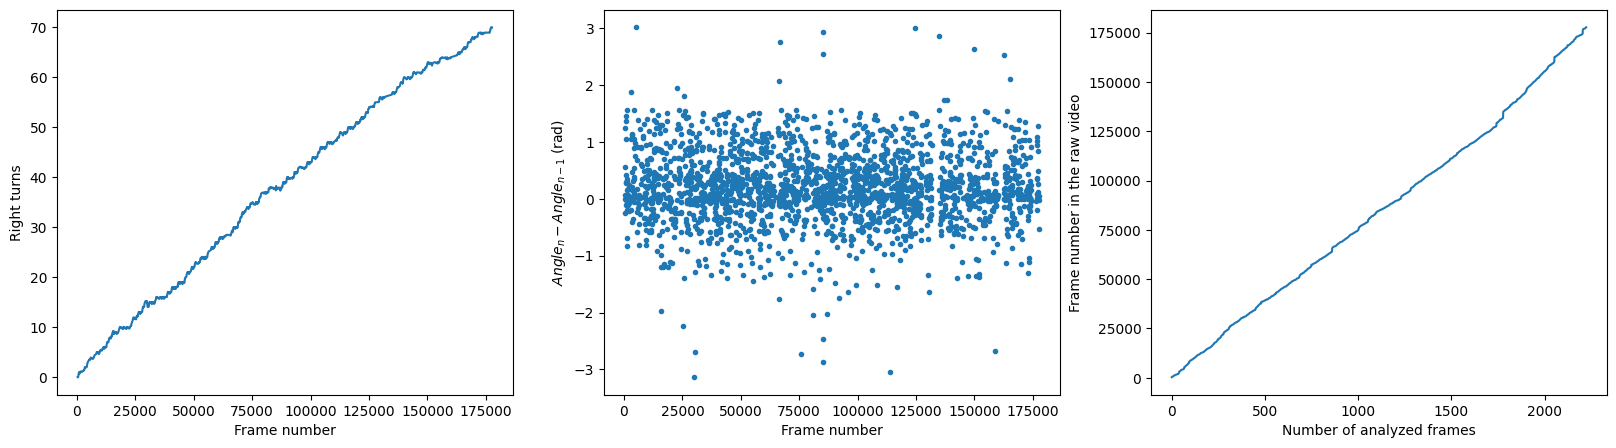

The animal made 69.95826304998393 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1797  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1785/1797 [01:13<00:00, 24.32it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  632  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 630/632 [00:25<00:00, 24.26it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  711  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 710/711 [00:29<00:00, 24.26it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  659  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 650/659 [00:27<00:00, 23.49it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  554  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 550/554 [00:23<00:00, 23.81it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  487  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 480/487 [00:20<00:00, 23.88it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  305  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 300/305 [00:12<00:00, 23.27it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  173  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 170/173 [00:07<00:00, 23.08it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  85  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 80/85 [00:03<00:00, 20.91it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  46  found with (before cropping) frame dimensions:  1000 750


 87%|████████▋ | 40/46 [00:02<00:00, 18.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  23  found with (before cropping) frame dimensions:  1000 750


 87%|████████▋ | 20/23 [00:01<00:00, 16.41it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  7  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/7 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2085 out of 5485 frames are good.
2082 out of 2085 frames are good after filtering.


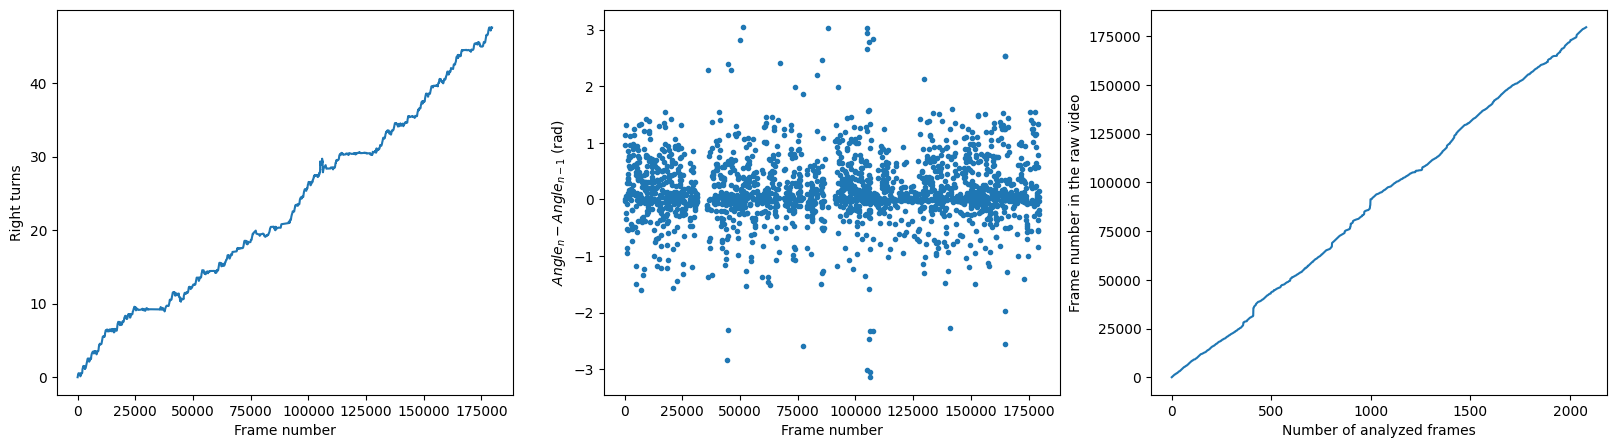

The animal made 47.516088226258525 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\Image_Segment3
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:13<00:00, 24.25it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\Image_Segment3...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  741  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 740/741 [00:30<00:00, 24.25it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  676  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 670/676 [00:28<00:00, 23.81it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  602  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 600/602 [00:24<00:00, 24.28it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  534  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 530/534 [00:22<00:00, 24.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  447  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 440/447 [00:18<00:00, 23.82it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  264  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 260/264 [00:11<00:00, 23.52it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  128  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 120/128 [00:05<00:00, 21.99it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  108  found with (before cropping) frame dimensions:  1000 750


 93%|█████████▎| 100/108 [00:04<00:00, 20.77it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  27  found with (before cropping) frame dimensions:  1000 750


 74%|███████▍  | 20/27 [00:01<00:00, 13.62it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  24  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 20/24 [00:01<00:00, 16.40it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New11_Segment3/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New11_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New12_Segment3/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New12_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New13_Segment3/
Starting to extract posture
Overall # of frames:  5  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/5 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New13_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New14_Segment3/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New14_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New15_Segment3/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New15_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New16_Segment3/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220825_video\Temp\New16_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2288 out of 5379 frames are good.
2285 out of 2288 frames are good after filtering.


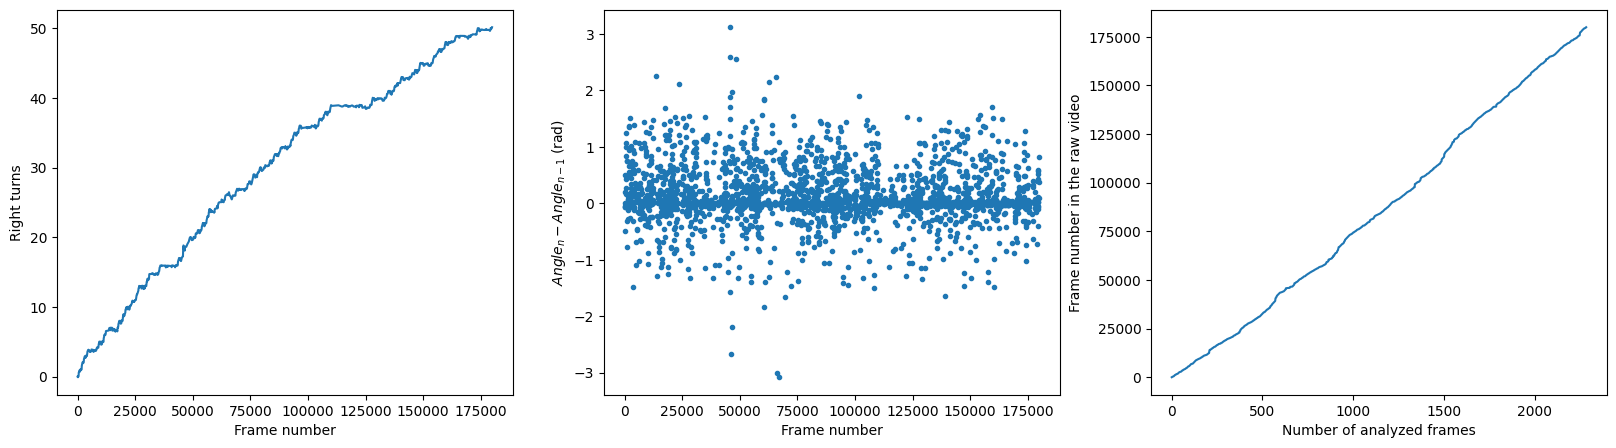

The animal made 50.14309232282608 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220826_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\Image_Segment1
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\Image_Segment1\Image_Segment1DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  860  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 850/860 [00:35<00:00, 24.02it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  609  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 600/609 [00:25<00:00, 23.86it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  606  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 600/606 [00:25<00:00, 23.76it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  533  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 530/533 [00:21<00:00, 24.20it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  443  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 440/443 [00:18<00:00, 24.08it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  246  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 240/246 [00:10<00:00, 23.41it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  129  found with (before cropping) frame dimensions:  1000 750


 93%|█████████▎| 120/129 [00:05<00:00, 21.26it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  64  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 60/64 [00:02<00:00, 20.82it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  21  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 20/21 [00:01<00:00, 17.44it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  1000 750


 56%|█████▌    | 10/18 [00:01<00:00,  8.81it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2589 out of 5335 frames are good.
2584 out of 2589 frames are good after filtering.


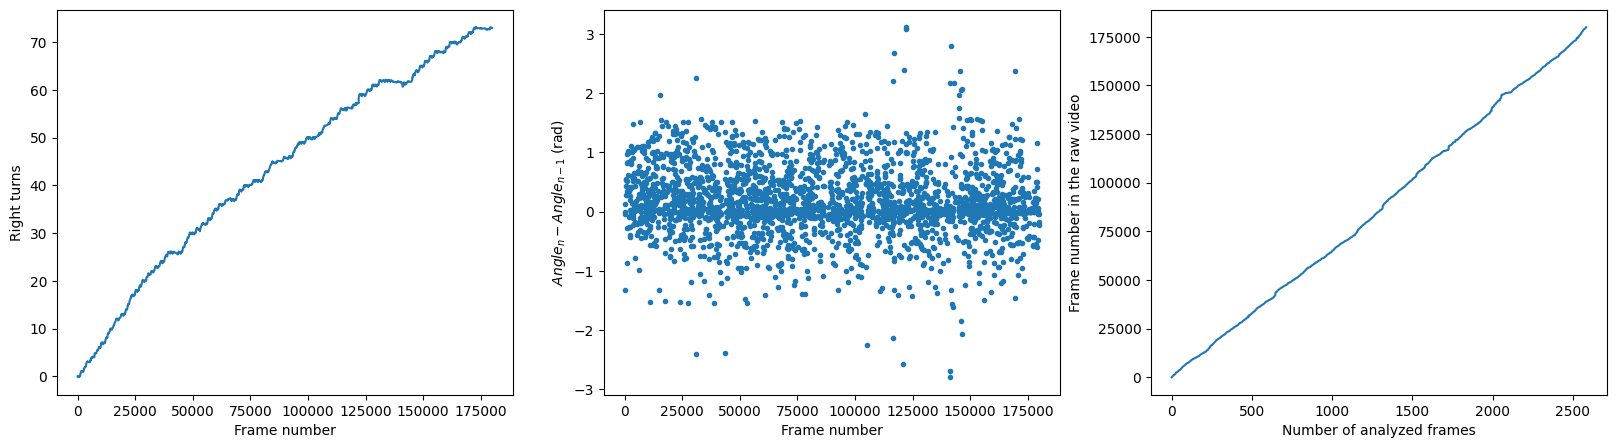

The animal made 73.0030556736848 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\Image_Segment2
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\Image_Segment2\Image_Segment2DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  619  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 610/619 [00:25<00:00, 24.25it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  571  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 570/571 [00:23<00:00, 24.10it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  554  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 550/554 [00:22<00:00, 23.95it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  475  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 470/475 [00:19<00:00, 24.01it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  409  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 400/409 [00:16<00:00, 23.57it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  213  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 210/213 [00:09<00:00, 23.28it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  104  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 100/104 [00:04<00:00, 22.25it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  65  found with (before cropping) frame dimensions:  1000 750


 92%|█████████▏| 60/65 [00:03<00:00, 19.46it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  26  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 20/26 [00:01<00:00, 13.56it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220826_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2244 out of 4846 frames are good.
2236 out of 2244 frames are good after filtering.


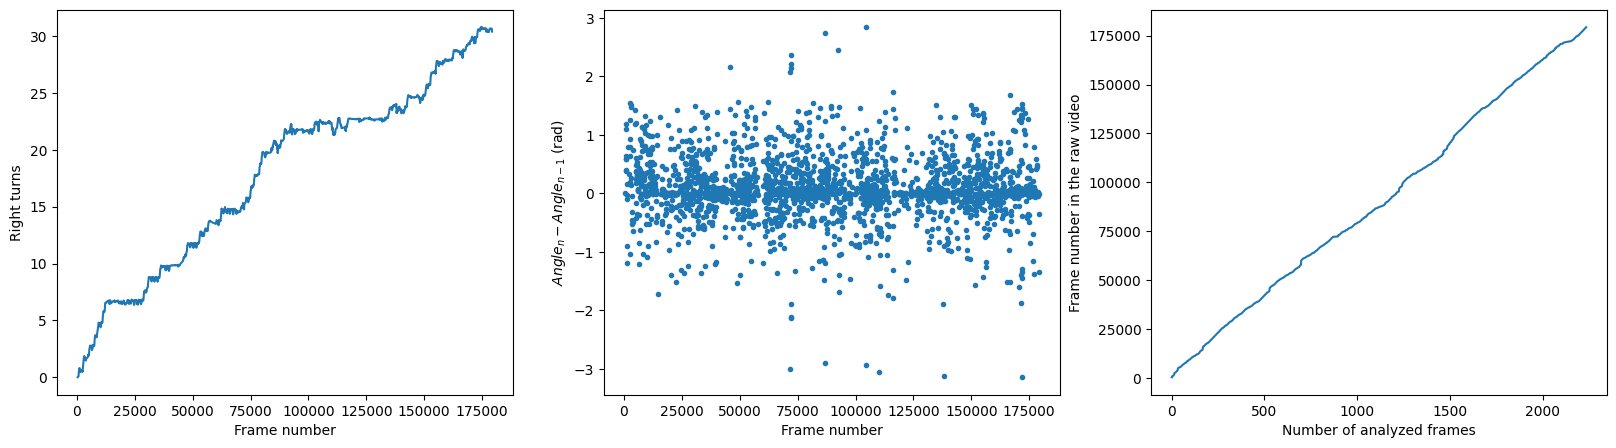

The animal made 30.40212516659898 right turns in segment 2
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220828_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\Image_Segment1
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\Image_Segment1\Image_Segment1DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  669  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 660/669 [00:27<00:00, 24.29it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  563  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 560/563 [00:23<00:00, 24.12it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  476  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 470/476 [00:19<00:00, 23.90it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  399  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 390/399 [00:16<00:00, 23.76it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  334  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 330/334 [00:13<00:00, 23.83it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  188  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 180/188 [00:07<00:00, 22.64it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  109  found with (before cropping) frame dimensions:  1000 750


 92%|█████████▏| 100/109 [00:04<00:00, 20.95it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  89  found with (before cropping) frame dimensions:  1000 750


 90%|████████▉ | 80/89 [00:04<00:00, 19.63it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  53  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 50/53 [00:02<00:00, 19.97it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  22  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 20/22 [00:01<00:00, 17.29it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/10 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New14_Segment1/
Starting to extract posture
Overall # of frames:  5  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/5 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New14_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New15_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New15_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2233 out of 4736 frames are good.
2230 out of 2233 frames are good after filtering.


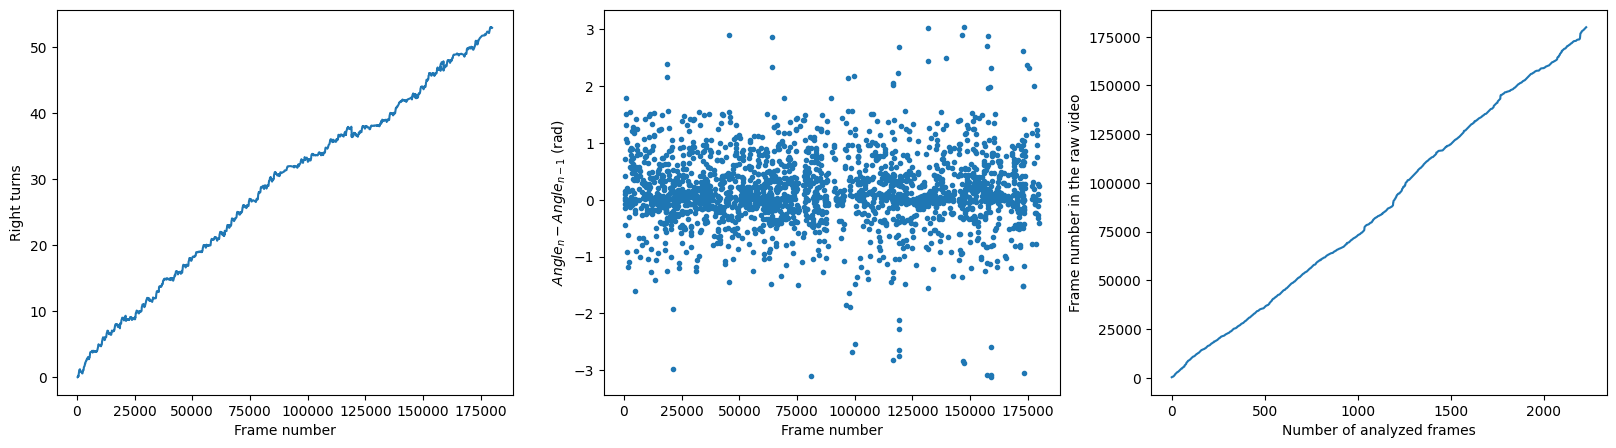

The animal made 52.917418790785206 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\Image_Segment2
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\Image_Segment2\Image_Segment2DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  529  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 520/529 [00:21<00:00, 23.66it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  615  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 610/615 [00:25<00:00, 24.11it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  594  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 590/594 [00:24<00:00, 23.74it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  568  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 560/568 [00:23<00:00, 23.87it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  425  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 420/425 [00:17<00:00, 23.69it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  257  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 250/257 [00:11<00:00, 22.68it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  172  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 170/172 [00:07<00:00, 22.94it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  124  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 120/124 [00:05<00:00, 22.23it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  71  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 70/71 [00:03<00:00, 22.64it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  43  found with (before cropping) frame dimensions:  1000 750


 93%|█████████▎| 40/43 [00:02<00:00, 18.67it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  12  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 10/12 [00:00<00:00, 12.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  13  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 10/13 [00:00<00:00, 11.96it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New14_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New14_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New15_Segment2/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New15_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New16_Segment2/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New16_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New17_Segment2/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New17_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New18_Segment2/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New18_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2263 out of 5240 frames are good.
2258 out of 2263 frames are good after filtering.


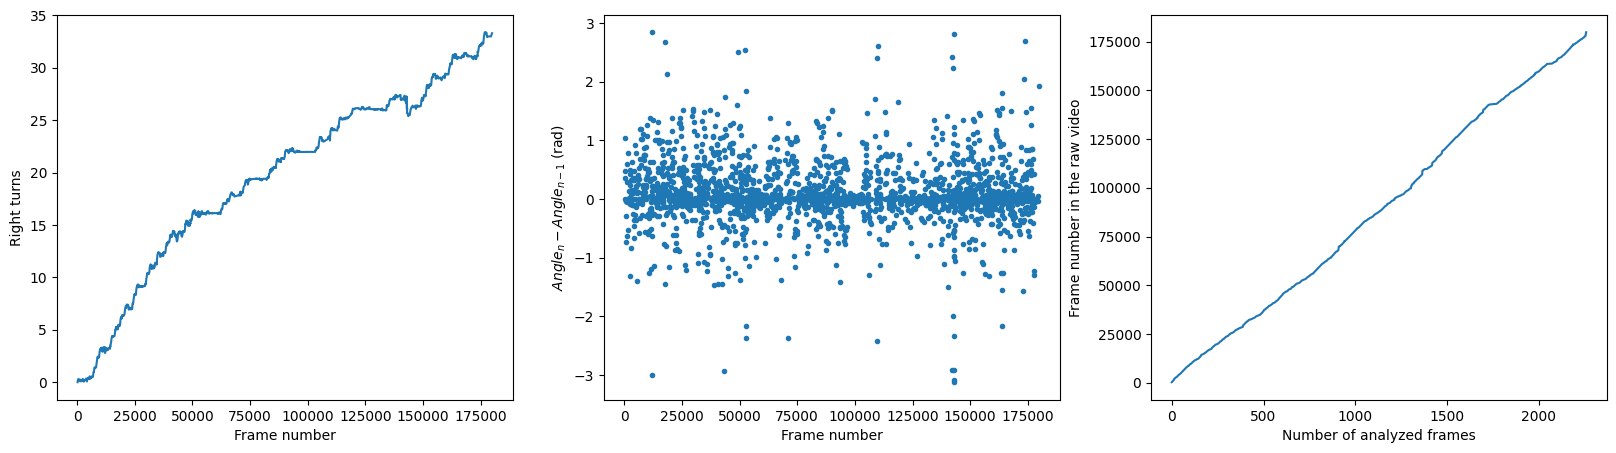

The animal made 33.30375946420066 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\Image_Segment3
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\Image_Segment3\Image_Segment3DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  309  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 300/309 [00:13<00:00, 22.99it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  357  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 350/357 [00:14<00:00, 23.46it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  306  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 300/306 [00:12<00:00, 23.26it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  280  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▋| 270/280 [00:11<00:00, 22.83it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  224  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 220/224 [00:09<00:00, 23.42it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  142  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 140/142 [00:06<00:00, 22.58it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  90  found with (before cropping) frame dimensions:  1000 750


 89%|████████▉ | 80/90 [00:04<00:00, 19.56it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  64  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 60/64 [00:02<00:00, 21.13it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  27  found with (before cropping) frame dimensions:  1000 750


 74%|███████▍  | 20/27 [00:01<00:00, 13.71it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  14  found with (before cropping) frame dimensions:  1000 750


 71%|███████▏  | 10/14 [00:00<00:00, 11.49it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New11_Segment3/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  1000 750


 56%|█████▌    | 10/18 [00:01<00:00,  9.17it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New11_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New12_Segment3/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220828_video\Temp\New12_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1372 out of 3639 frames are good.
1368 out of 1372 frames are good after filtering.


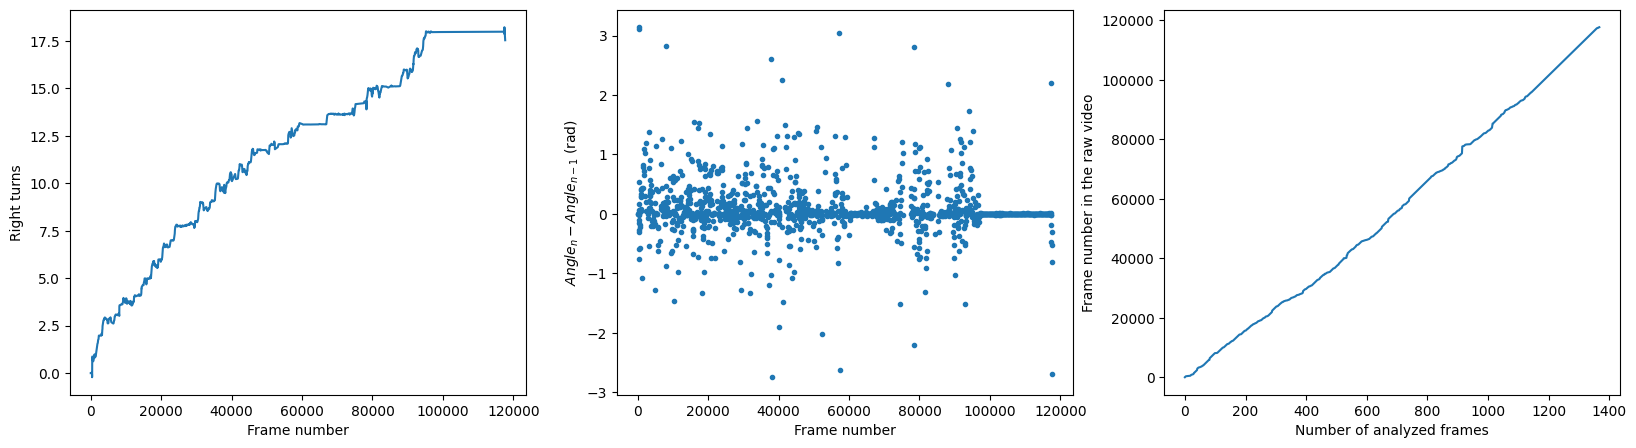

The animal made 17.535553868670757 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220830_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\Image_Segment1
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\Image_Segment1\Image_Segment1DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  810  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 800/810 [00:33<00:00, 23.84it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  463  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 460/463 [00:19<00:00, 24.14it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  385  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 380/385 [00:16<00:00, 23.26it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  358  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 350/358 [00:14<00:00, 23.35it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  283  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 280/283 [00:12<00:00, 23.28it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  188  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 180/188 [00:07<00:00, 22.58it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  124  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 120/124 [00:05<00:00, 22.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  87  found with (before cropping) frame dimensions:  1000 750


 92%|█████████▏| 80/87 [00:03<00:00, 21.10it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  33  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 30/33 [00:01<00:00, 16.50it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  13  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 10/13 [00:00<00:00, 11.86it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  5  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/5 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2500 out of 4552 frames are good.
2492 out of 2500 frames are good after filtering.


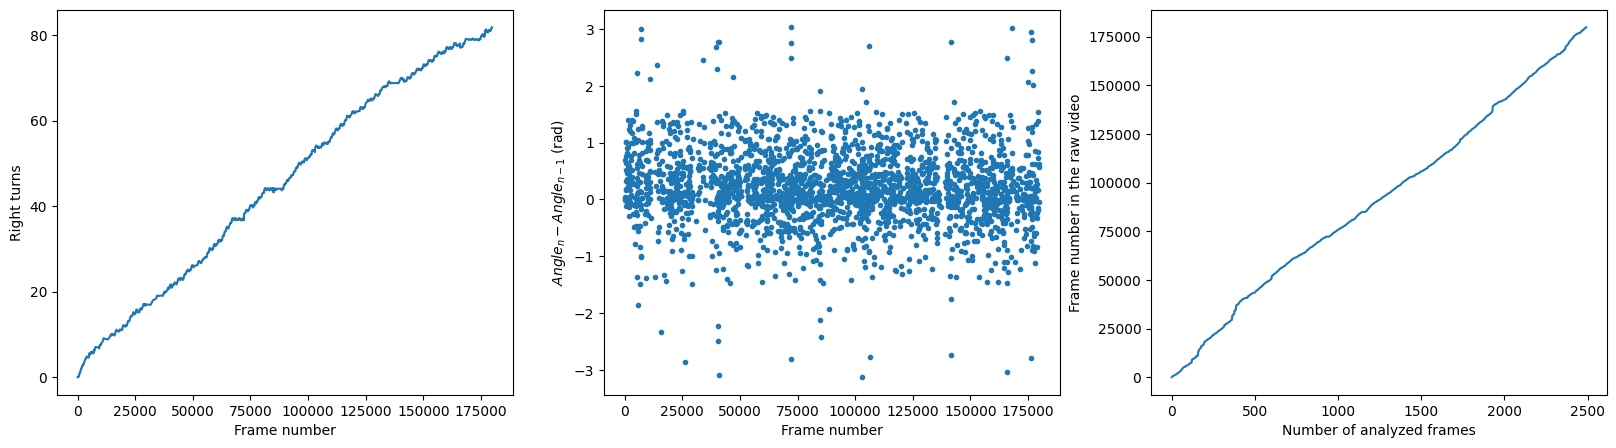

The animal made 81.81406434567796 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\Image_Segment2
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\Image_Segment2\Image_Segment2DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  774  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 770/774 [00:31<00:00, 24.46it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  621  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 620/621 [00:25<00:00, 24.69it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  604  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 600/604 [00:24<00:00, 24.59it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  561  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 560/561 [00:23<00:00, 24.20it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  419  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 410/419 [00:17<00:00, 23.50it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  269  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 260/269 [00:11<00:00, 23.17it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  170  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 160/170 [00:07<00:00, 22.11it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  131  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 130/131 [00:05<00:00, 22.84it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  69  found with (before cropping) frame dimensions:  1000 750


 87%|████████▋ | 60/69 [00:03<00:00, 19.51it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  42  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 40/42 [00:02<00:00, 18.60it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  36  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 30/36 [00:01<00:00, 16.83it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  15  found with (before cropping) frame dimensions:  1000 750


 67%|██████▋   | 10/15 [00:00<00:00, 11.17it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  12  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 10/12 [00:00<00:00, 12.33it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New14_Segment2/
Starting to extract posture
Overall # of frames:  7  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/7 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New14_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New15_Segment2/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New15_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2512 out of 5532 frames are good.
2509 out of 2512 frames are good after filtering.


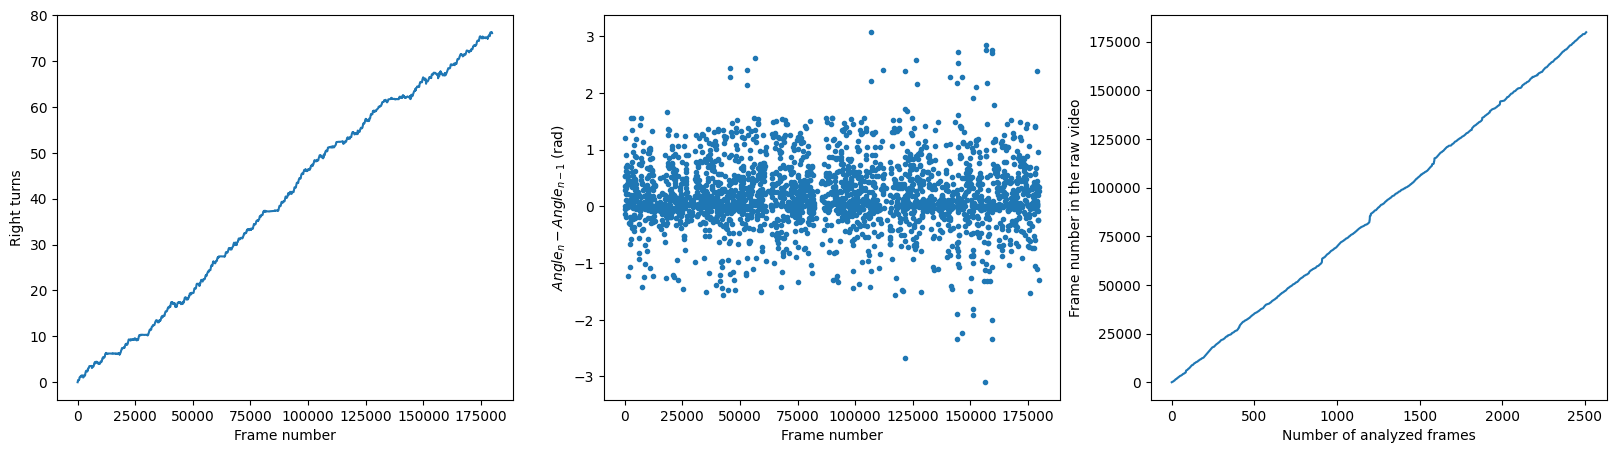

The animal made 76.0893548212643 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\Image_Segment3
Frames already analyzed! G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\Image_Segment3\Image_Segment3DLC_resnet50_Max_topviewJul21shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  659  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 650/659 [00:26<00:00, 24.27it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  499  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 490/499 [00:20<00:00, 23.67it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  397  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 390/397 [00:16<00:00, 23.87it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  358  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 350/358 [00:14<00:00, 23.82it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  317  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 310/317 [00:13<00:00, 23.61it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  173  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 170/173 [00:07<00:00, 23.05it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  106  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 100/106 [00:04<00:00, 21.01it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  60  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 50/60 [00:02<00:00, 18.03it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  12  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 10/12 [00:00<00:00, 12.14it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  11  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 10/11 [00:00<00:00, 12.45it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220830_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2292 out of 4392 frames are good.
2286 out of 2292 frames are good after filtering.


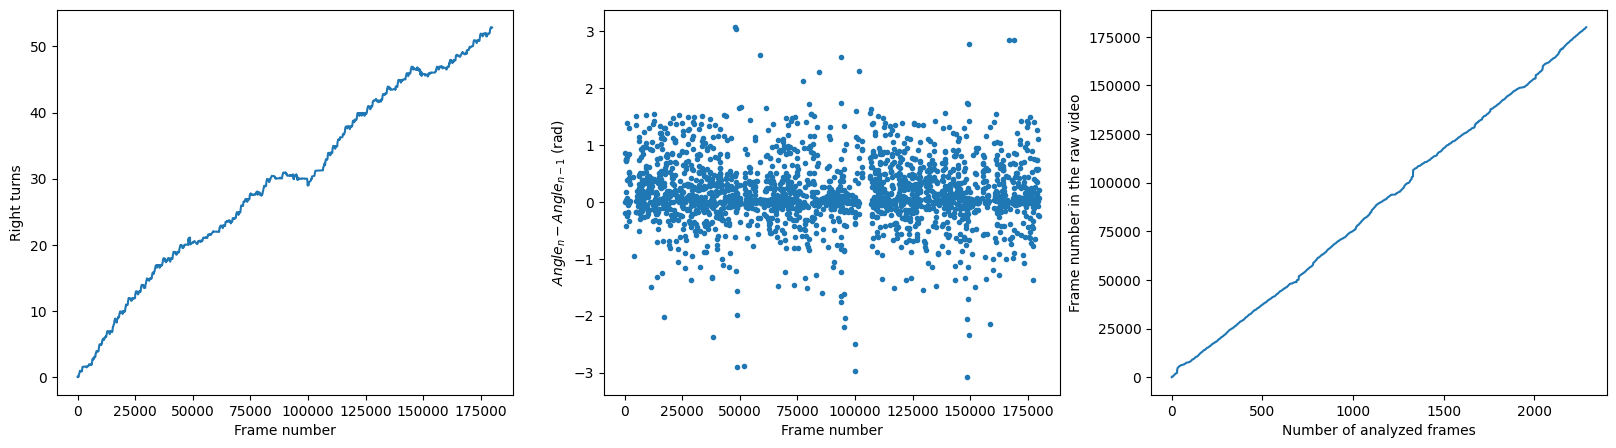

The animal made 52.87184882723884 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220730_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1794  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1785/1794 [01:12<00:00, 24.49it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  742  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 740/742 [00:30<00:00, 24.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  379  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 370/379 [00:15<00:00, 23.20it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  290  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 280/290 [00:12<00:00, 22.77it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  231  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 230/231 [00:09<00:00, 23.80it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  216  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 210/216 [00:09<00:00, 23.14it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  143  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 140/143 [00:06<00:00, 22.71it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  96  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 90/96 [00:04<00:00, 21.73it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  67  found with (before cropping) frame dimensions:  1000 750


 90%|████████▉ | 60/67 [00:03<00:00, 19.15it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  22  found with (before cropping) frame dimensions:  1000 750


 91%|█████████ | 20/22 [00:01<00:00, 17.09it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  19  found with (before cropping) frame dimensions:  1000 750


 53%|█████▎    | 10/19 [00:01<00:01,  8.81it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2277 out of 4010 frames are good.
2272 out of 2277 frames are good after filtering.


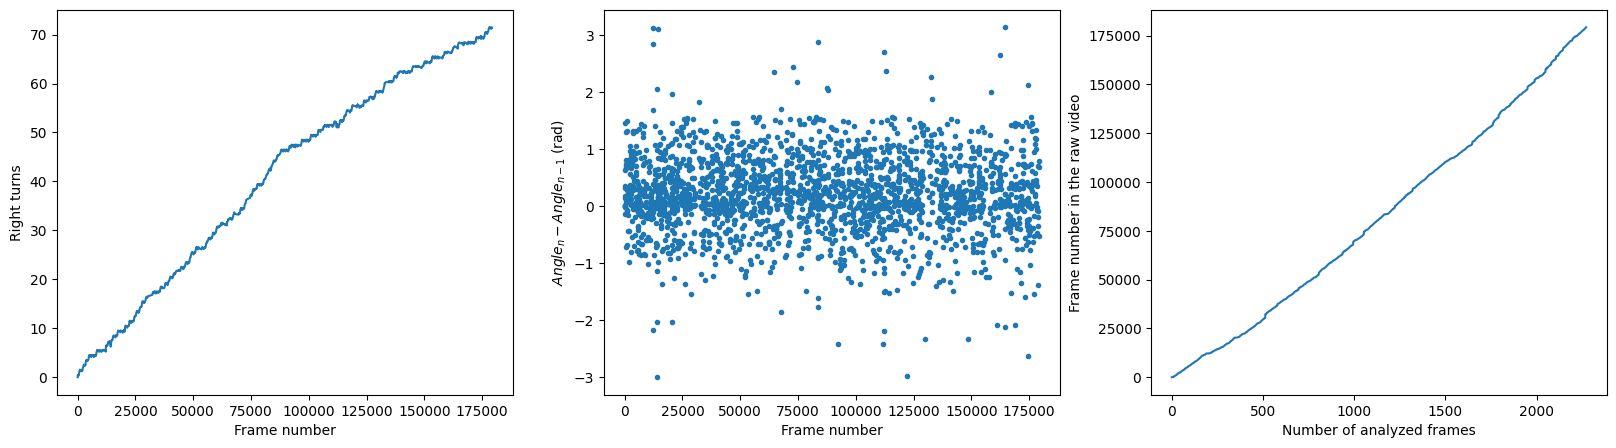

The animal made 71.40615830246031 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:12<00:00, 24.45it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 790/800 [00:33<00:00, 23.84it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  643  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 640/643 [00:26<00:00, 24.07it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  636  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 630/636 [00:26<00:00, 23.76it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  559  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 550/559 [00:23<00:00, 23.69it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  451  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 450/451 [00:18<00:00, 23.85it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  251  found with (before cropping) frame dimensions:  1000 750


100%|█████████▉| 250/251 [00:10<00:00, 23.36it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  165  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 160/165 [00:07<00:00, 22.67it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  104  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 100/104 [00:04<00:00, 22.07it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  31  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 30/31 [00:01<00:00, 19.87it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  26  found with (before cropping) frame dimensions:  1000 750


 77%|███████▋  | 20/26 [00:01<00:00, 13.50it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  29  found with (before cropping) frame dimensions:  1000 750


 69%|██████▉   | 20/29 [00:01<00:00, 13.09it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  20  found with (before cropping) frame dimensions:  1000 750


 50%|█████     | 10/20 [00:01<00:01,  8.56it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New14_Segment2/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New14_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New15_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New15_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2472 out of 5531 frames are good.
2469 out of 2472 frames are good after filtering.


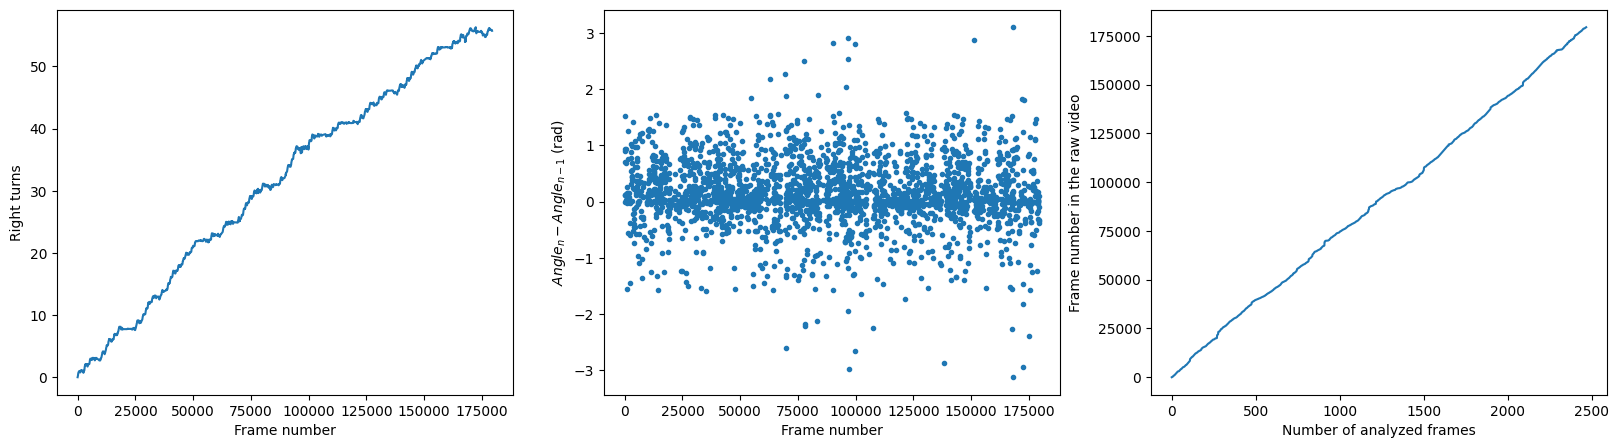

The animal made 55.72777964805962 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\Image_Segment3
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:13<00:00, 24.14it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\Image_Segment3...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New1_Segment3/
Starting to extract posture
Overall # of frames:  553  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 550/553 [00:23<00:00, 23.56it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New2_Segment3/
Starting to extract posture
Overall # of frames:  506  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 500/506 [00:20<00:00, 23.95it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New3_Segment3/
Starting to extract posture
Overall # of frames:  410  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 400/410 [00:17<00:00, 23.35it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New4_Segment3/
Starting to extract posture
Overall # of frames:  339  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 330/339 [00:14<00:00, 23.44it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New5_Segment3/
Starting to extract posture
Overall # of frames:  297  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 290/297 [00:12<00:00, 23.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New6_Segment3/
Starting to extract posture
Overall # of frames:  213  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 210/213 [00:08<00:00, 23.35it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New7_Segment3/
Starting to extract posture
Overall # of frames:  121  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 120/121 [00:05<00:00, 23.00it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New8_Segment3/
Starting to extract posture
Overall # of frames:  83  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▋| 80/83 [00:03<00:00, 21.33it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New9_Segment3/
Starting to extract posture
Overall # of frames:  71  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 70/71 [00:03<00:00, 21.95it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New10_Segment3/
Starting to extract posture
Overall # of frames:  29  found with (before cropping) frame dimensions:  1000 750


 69%|██████▉   | 20/29 [00:01<00:00, 13.09it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New11_Segment3/
Starting to extract posture
Overall # of frames:  17  found with (before cropping) frame dimensions:  1000 750


 59%|█████▉    | 10/17 [00:01<00:00,  8.92it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New11_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New12_Segment3/
Starting to extract posture
Overall # of frames:  15  found with (before cropping) frame dimensions:  1000 750


 67%|██████▋   | 10/15 [00:00<00:00, 11.77it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New12_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New13_Segment3/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New13_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New14_Segment3/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220730_video\Temp\New14_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2120 out of 4463 frames are good.
2118 out of 2120 frames are good after filtering.


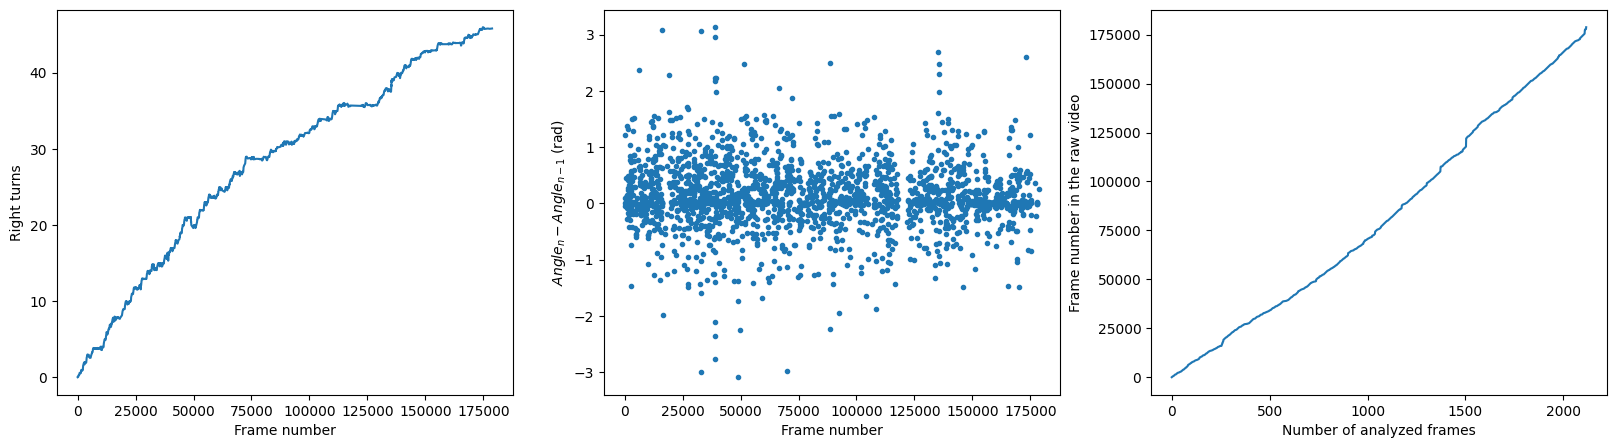

The animal made 45.79328905254106 right turns in segment 3
Analyzing G:\M1_Ephys\Ephys\Max\Videos\20220731_video ...
Temp folder: G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1795  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1785/1795 [01:12<00:00, 24.52it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  579  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 570/579 [00:23<00:00, 24.00it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  429  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 420/429 [00:17<00:00, 23.88it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  320  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 310/320 [00:13<00:00, 23.50it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  244  found with (before cropping) frame dimensions:  1000 750


 98%|█████████▊| 240/244 [00:10<00:00, 23.28it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  189  found with (before cropping) frame dimensions:  1000 750


 95%|█████████▌| 180/189 [00:08<00:00, 22.06it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  106  found with (before cropping) frame dimensions:  1000 750


 94%|█████████▍| 100/106 [00:04<00:00, 21.17it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  65  found with (before cropping) frame dimensions:  1000 750


 92%|█████████▏| 60/65 [00:03<00:00, 19.51it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  30  found with (before cropping) frame dimensions:  1000 750


 67%|██████▋   | 20/30 [00:01<00:00, 13.00it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  20  found with (before cropping) frame dimensions:  1000 750


 50%|█████     | 10/20 [00:01<00:01,  8.69it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2287 out of 3789 frames are good.
2287 out of 2287 frames are good after filtering.


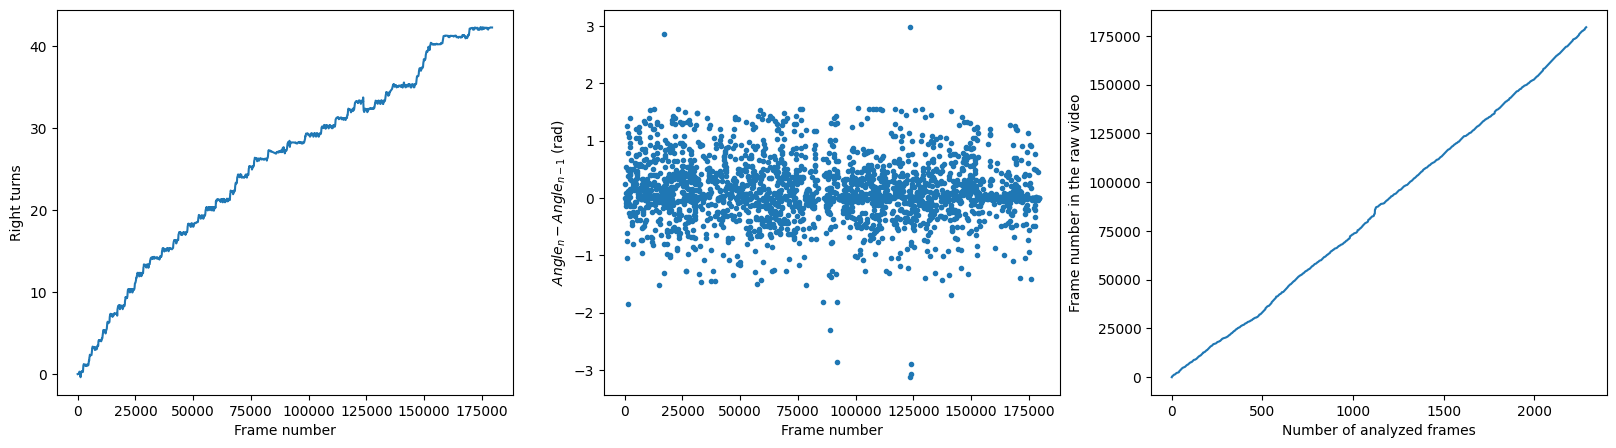

The animal made 42.25513308153426 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 1782/1800 [01:13<00:00, 24.34it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  573  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 570/573 [00:23<00:00, 24.07it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  596  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 590/596 [00:24<00:00, 23.91it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  517  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▊| 510/517 [00:21<00:00, 23.72it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  433  found with (before cropping) frame dimensions:  1000 750


 99%|█████████▉| 430/433 [00:18<00:00, 23.79it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  318  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 310/318 [00:13<00:00, 23.22it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  209  found with (before cropping) frame dimensions:  1000 750


 96%|█████████▌| 200/209 [00:08<00:00, 22.61it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  154  found with (before cropping) frame dimensions:  1000 750


 97%|█████████▋| 150/154 [00:06<00:00, 22.71it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  98  found with (before cropping) frame dimensions:  1000 750


 92%|█████████▏| 90/98 [00:04<00:00, 20.53it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  36  found with (before cropping) frame dimensions:  1000 750


 83%|████████▎ | 30/36 [00:01<00:00, 16.38it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  19  found with (before cropping) frame dimensions:  1000 750


 53%|█████▎    | 10/19 [00:01<00:01,  8.72it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  15  found with (before cropping) frame dimensions:  1000 750


 67%|██████▋   | 10/15 [00:00<00:00, 11.11it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  14  found with (before cropping) frame dimensions:  1000 750


 71%|███████▏  | 10/14 [00:00<00:00, 11.59it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Max_topview-HY-2023-07-21\dlc-models\iteration-0\Max_topviewJul21-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  7  found with (before cropping) frame dimensions:  1000 750


  0%|          | 0/7 [00:00<?, ?it/s]


Saving results in G:\M1_Ephys\Ephys\Max\Videos\20220731_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2083 out of 4789 frames are good.
2075 out of 2083 frames are good after filtering.


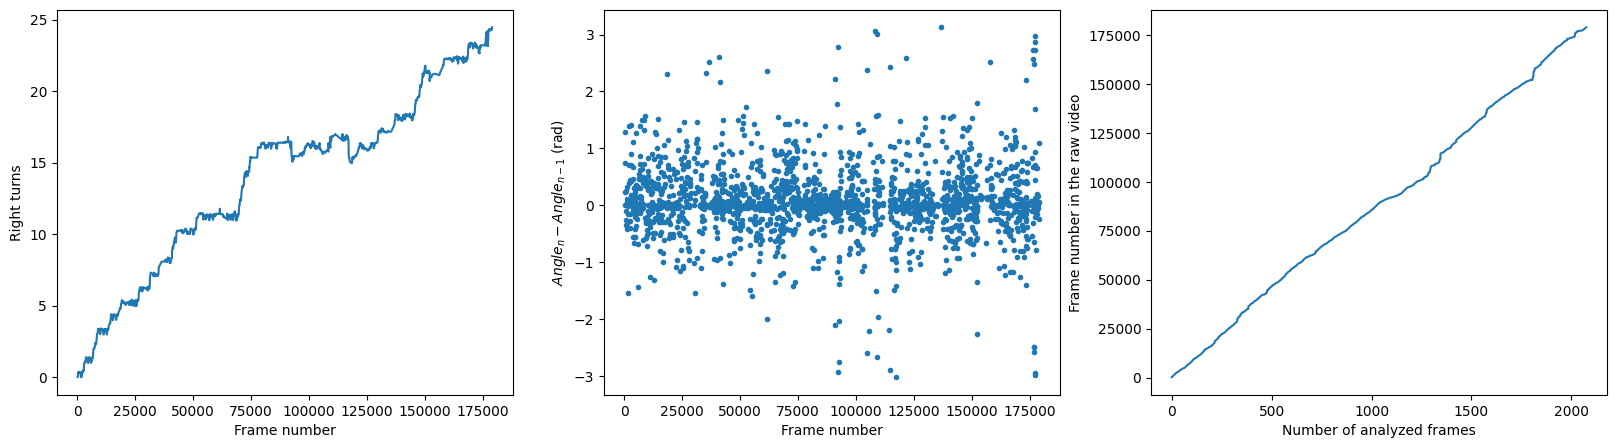

The animal made 24.469190441401953 right turns in segment 2


In [3]:
dir_to_analysis = r'G:\M1_Ephys\Ephys\Max\Videos'
sessions = [
    '20220701',
    '20220702',
    '20220716',
    '20220717',
    '20220718',
    '20220719',
    '20220720',
    '20220721',
    '20220722',
    '20220723',
    '20220726',
    '20220727',
    '20220728',
    '20220729',
    '20220730',
    '20220731',
    '20220817',
    '20220818',
    '20220819',
    '20220823',
    '20220824',
    '20220825',
    '20220826',
    '20220828',
    '20220830']
dlc_model = r'D:\DLC\Max_topview-HY-2023-07-21\config.yaml'
frame_interval = 100

p_thres = 0.9
v_angle_thres = 0.5*np.pi

for session in sessions:
    dir_video = os.path.join(dir_to_analysis, session + '_video')
    dir_temp = os.path.join(dir_video, 'Temp')
    dir_image = os.path.join(dir_temp, 'Image')
    print('Analyzing', dir_video, '...')
    print('Temp folder:', dir_temp)

    ts = h5py.File(os.path.join(dir_video, 'timestamps.mat'))
    n_files = ts['ts']['topviews'].size
    n_char = ts[ts['ts']['topviews'][0][0]].size
    video_path_all = []
    for k in range(n_files):
        filename = ''
        for j in range(n_char):
            filename += chr(ts[ts['ts']['topviews'][0][k]][j][0])

        video_path_all.append(filename)

    # Start analysis
    for k in range(len(video_path_all)):
        segment_num = k+1
        video_path = video_path_all[k]
        df_out = analyze_segment(segment_num, os.path.join(dir_video, video_path), dir_temp, dir_video)

        turning_angle = df_out['turning_angle'].to_numpy()
        d_angle = df_out['d_angle']

        plt.figure(figsize=(20,5))

        plt.subplot(1,3,1)
        plt.plot(df_out['frame_number'].to_numpy(), turning_angle/np.pi/2)
        plt.ylabel('Right turns')
        plt.xlabel('Frame number')

        plt.subplot(1,3,2)
        plt.plot(df_out['frame_number'].to_numpy(), d_angle, '.')
        plt.ylabel('$Angle_n - Angle_{n-1}$ (rad)', )
        plt.xlabel('Frame number')

        plt.subplot(1,3,3)
        plt.plot(df_out['frame_number'].to_numpy())
        plt.ylabel('Frame number in the raw video')
        plt.xlabel('Number of analyzed frames')

        plt.show()

        print('The animal made', turning_angle[-1]/np.pi/2, 'right turns in segment', segment_num)
